# Cyclistic Case Study: Exploratory Data Analysis (EDA)

This notebook explores the cleaned Cyclistic trip dataset (Dec 2024 – Nov 2025).  

Goals:
- Understand trip volumes and seasonality
- Compare member vs casual riders
- Explore trip duration distributions
- Visualize rideable types and station usage


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import viz_helpers as vh
# Load cleaned dataset
df = pd.read_csv("cyclistic_cleaned_rolling_dec2024_nov2025.csv")

# Convert datetime columns
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Quick check
df.info()
df.head()
df['start_station_name'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5438437 entries, 0 to 5438436
Data columns (total 15 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
 13  trip_duration_min   float64       
 14  year_month          object        
dtypes: datetime64[ns](2), float64(5), object(8)
memory usage: 622.4+ MB


start_station_name
Kingsbury St & Kinzie St                   41519
Dusable Lake Shore Dr & Monroe St          39084
Michigan Ave & Oak St                      34646
Navy Pier                                  34223
Dusable Lake Shore Dr & North Blvd         33235
                                           ...  
Public Rack - Keeler Ave & Madison St S        1
Public Rack - Brainerd Park                    1
Public Rack - Pulaski Rd & Grenshaw St         1
Public Rack - Austin & Higgins                 1
Public Rack - Zapata Academy                   1
Name: count, Length: 1854, dtype: int64

In [3]:
df['start_station_id'].nunique()

3299

## Monthly Trip Counts

We’ll examine seasonality by plotting monthly trip counts across the rolling year.


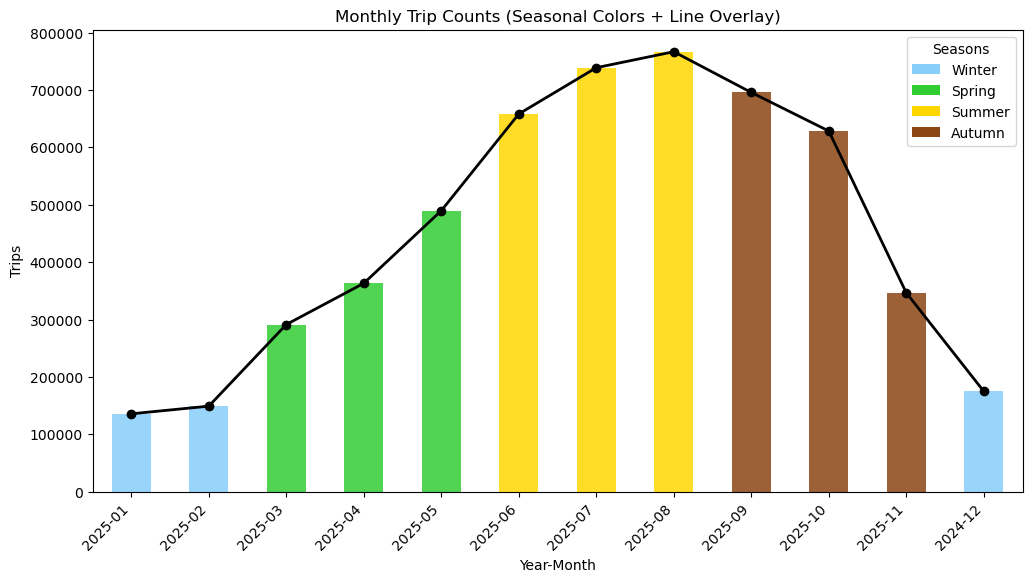

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ----------------------------
# 1. Group by year-month
# ----------------------------
df['started_at'] = pd.to_datetime(df['started_at'])
df['year_month'] = df['started_at'].dt.to_period('M')
monthly_counts = df.groupby('year_month').size()

# ----------------------------
# 2. Custom order (Jan–Nov 2025, then Dec 2024)
# ----------------------------
custom_order = [
    pd.Period('2025-01', freq='M'),
    pd.Period('2025-02', freq='M'),
    pd.Period('2025-03', freq='M'),
    pd.Period('2025-04', freq='M'),
    pd.Period('2025-05', freq='M'),
    pd.Period('2025-06', freq='M'),
    pd.Period('2025-07', freq='M'),
    pd.Period('2025-08', freq='M'),
    pd.Period('2025-09', freq='M'),
    pd.Period('2025-10', freq='M'),
    pd.Period('2025-11', freq='M'),
    pd.Period('2024-12', freq='M')
]
monthly_counts = monthly_counts.reindex(custom_order, fill_value=0)

# Convert PeriodIndex to string for plotting
monthly_counts.index = monthly_counts.index.astype(str)

# ----------------------------
# 3. Define seasonal colors (refined palette)
# ----------------------------
season_colors = {
    '12': '#87CEFA',  # Winter (light sky blue)
    '01': '#87CEFA',
    '02': '#87CEFA',
    '03': '#32CD32',  # Spring (lime green)
    '04': '#32CD32',
    '05': '#32CD32',
    '06': '#FFD700',  # Summer (gold)
    '07': '#FFD700',
    '08': '#FFD700',
    '09': '#8B4513',  # Autumn (saddle brown)
    '10': '#8B4513',
    '11': '#8B4513'
}

# Build color list for each month in custom order
bar_colors = [season_colors[m[-2:]] for m in monthly_counts.index]

# ----------------------------
# 4. Plot bars + line overlay
# ----------------------------
ax = monthly_counts.plot(
    kind='bar',
    figsize=(12,6),
    color=bar_colors,
    alpha=0.85,
    title="Monthly Trip Counts (Seasonal Colors + Line Overlay)"
)

# Overlay line trace
monthly_counts.plot(
    kind='line',
    marker='o',
    color='black',
    linewidth=2,
    ax=ax
)

# ----------------------------
# 5. Add legend for seasons
# ----------------------------
legend_elements = [
    Patch(facecolor='#87CEFA', label='Winter'),
    Patch(facecolor='#32CD32', label='Spring'),
    Patch(facecolor='#FFD700', label='Summer'),
    Patch(facecolor='#8B4513', label='Autumn')
]
ax.legend(handles=legend_elements, title="Seasons")

# Axis formatting
ax.set_xlabel("Year-Month")
ax.set_ylabel("Trips")
plt.xticks(rotation=45, ha='right')
plt.show()


In [6]:
# Define a function to map month to season
def month_to_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

# Create season column
df['season'] = df['started_at'].dt.month.apply(month_to_season)

# Quick check
df['season'].value_counts()


season
Summer    2163728
Autumn    1670789
Spring    1144154
Winter     459766
Name: count, dtype: int64

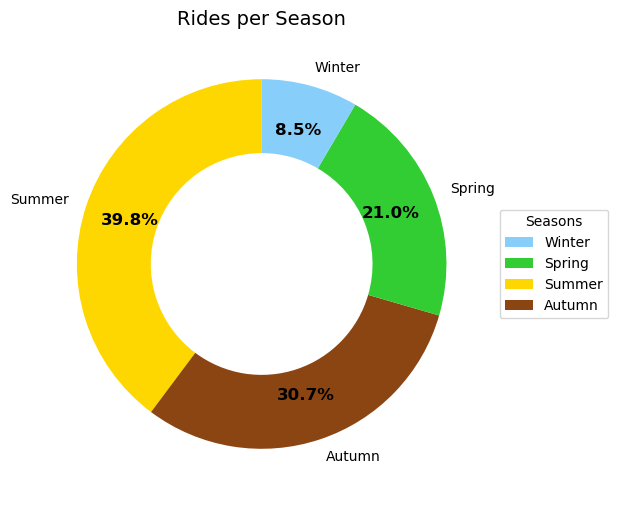

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Count rides per season
season_counts = df['season'].value_counts()

# Define seasonal colors (same refined palette)
season_palette = {
    'Winter': '#87CEFA',   # light sky blue
    'Spring': '#32CD32',   # lime green
    'Summer': '#FFD700',   # gold
    'Autumn': '#8B4513'    # saddle brown
}

# Map colors to the order of season_counts
colors = [season_palette[season] for season in season_counts.index]

# Plot donut chart
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(
    season_counts,
    labels=season_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.4),
    pctdistance=0.75   # move percentages into the middle of the ring
)

plt.setp(autotexts, size=12, weight="bold", color="black")
ax.set_title("Rides per Season", fontsize=14)
ax.legend(handles=[
    Patch(facecolor=season_palette['Winter'], label='Winter'),
    Patch(facecolor=season_palette['Spring'], label='Spring'),
    Patch(facecolor=season_palette['Summer'], label='Summer'),
    Patch(facecolor=season_palette['Autumn'], label='Autumn')
], title="Seasons", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


In [8]:
# Group by season and rider type
#season_rider = df.groupby(['season','member_casual']).size().unstack(fill_value=0)

# Ensure correct seasonal order
#season_order = ['Winter','Spring','Summer','Autumn']
#season_rider = season_rider.reindex(season_order)


In [9]:
#member_counts = df['member_casual'].value_counts().reindex(['member','casual'])

#ax = vh.plot_with_consistent_colors(
#    member_counts,
#    kind='bar',
#    title="Member vs Casual Trips",
#    figsize=(6,4),
#    category_type="rider",
 #   format_yaxis="human",   # <-- correct parameter name
#    unit=" trips"
#)

#plt.ylabel("Trips")
#plt.show()


## Member vs Casual Riders

We’ll compare trip counts between members and casual riders.


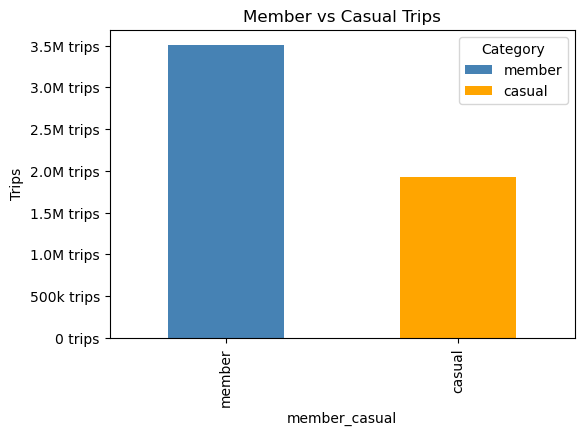

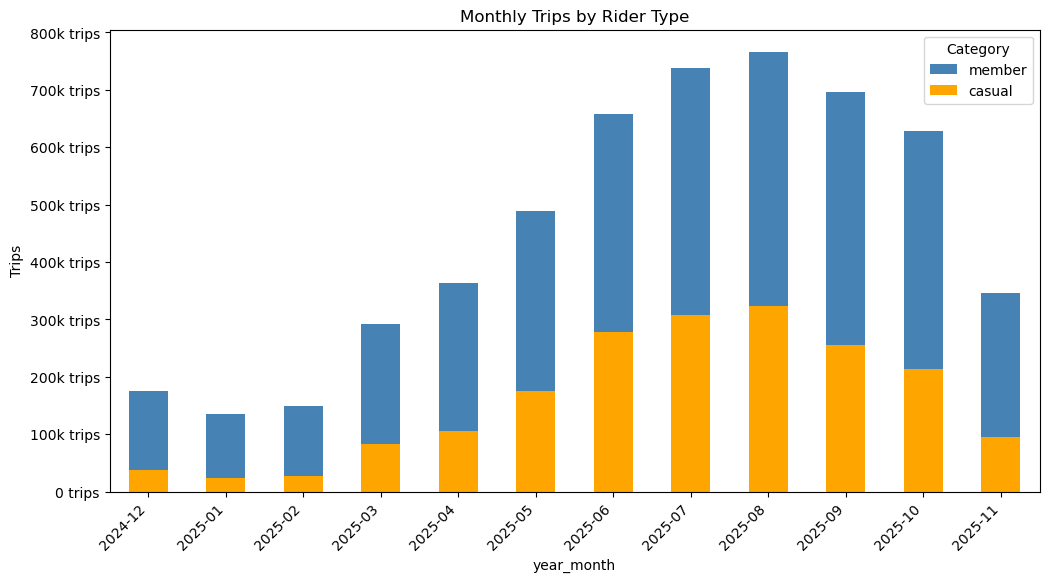

In [11]:
# -----------------------------
# Member vs Casual Trips
# -----------------------------
member_counts = df['member_casual'].value_counts().reindex(['member','casual'])

ax = vh.plot_with_consistent_colors(
    member_counts,
    kind='bar',
    title="Member vs Casual Trips",
    figsize=(6,4),
    category_type="rider",       # enforce rider palette
    format_yaxis="human",
    unit=" trips"
)
plt.ylabel("Trips")
plt.show()


# -----------------------------
# Monthly breakdown
# -----------------------------
monthly_member = df.groupby(['year_month','member_casual']).size().unstack(fill_value=0)

ax = vh.plot_with_consistent_colors(
    monthly_member,
    kind='bar',
    stacked=True,
    title="Monthly Trips by Rider Type",
    figsize=(12,6),
    category_type="rider",       # enforce rider palette
    format_yaxis="human",
    unit=" trips"
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Trips")
plt.show()


## Trip Duration Distribution

We’ll explore how long trips typically last.


In [13]:
#member_counts = df['member_casual'].value_counts().reindex(['member','casual'])

#ax = vh.plot_with_consistent_colors(
 #   member_counts,
 #   kind='bar',
 #   title="Member vs Casual Trips",
   # figsize=(6,4),
 #   category_type="rider",
  #  format_yaxis="human",   # <-- correct parameter name
  #  unit=" trips"
#)

#plt.ylabel("Trips")
#plt.show()


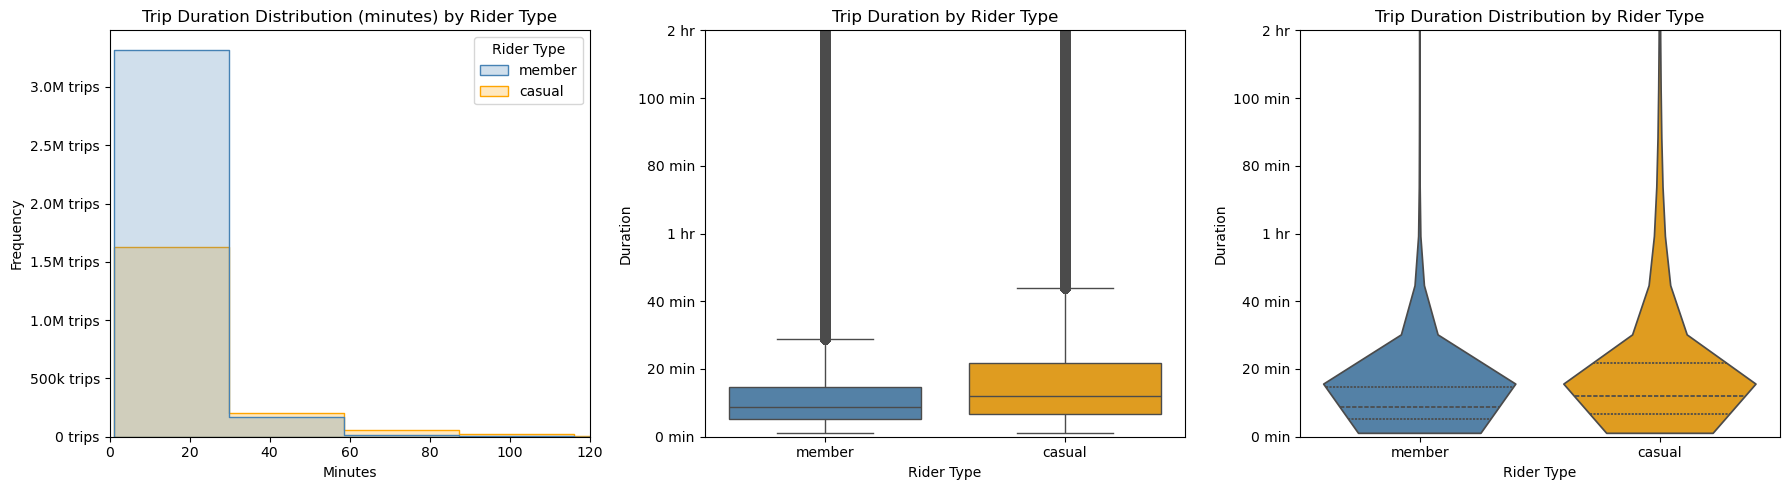

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import viz_helpers as vh  # ensure this import is at the top

# Create a 1x3 subplot grid
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# -----------------------------
# Histogram
# -----------------------------
#sns.histplot(df['trip_duration_min'], bins=50, kde=False, color='steelblue', ax=axes[0])
#axes[0].set_title("Trip Duration Distribution (minutes)")
#axes[0].set_xlabel("Minutes")
#axes[0].set_ylabel("Frequency")
#vh.human_format_yaxis(axes[0])  # optional; typically no unit for frequency
#axes[0].set_xlim(0, 120)
# -----------------------------
# Histogram with overlay by rider type
# -----------------------------
sns.histplot(
    data=df,
    x='trip_duration_min',
    hue='member_casual',          # separate distributions
    bins=50,
    kde=False,
    palette=vh.PALETTE_RIDER,     # enforce consistent colors
    ax=axes[0],
    element='step',               # overlay style (step outlines)
    stat='count',                 # show counts
    common_norm=False             # don't normalize across groups
)
axes[0].set_title("Trip Duration Distribution (minutes) by Rider Type")
axes[0].set_xlabel("Minutes")
axes[0].set_ylabel("Frequency")
vh.human_format_yaxis(axes[0], unit=" trips")
axes[0].set_xlim(0, 120)
#axes[0].legend(title="Rider Type")
axes[0].legend_.set_title("Rider Type")

# -----------------------------
# Boxplot
# -----------------------------
sns.boxplot(
    x='member_casual',
    y='trip_duration_min',
    hue='member_casual',
    data=df,
    ax=axes[1],
    palette=vh.PALETTE_RIDER,
    legend=False
)
axes[1].set_title("Trip Duration by Rider Type")
axes[1].set_xlabel("Rider Type")
axes[1].set_ylabel("Duration")
vh.format_duration_yaxis(axes[1], max_minutes=120)

# -----------------------------
# Violin plot
# -----------------------------
sns.violinplot(
    x='member_casual',
    y='trip_duration_min',
    hue='member_casual',
    data=df,
    ax=axes[2],
    palette=vh.PALETTE_RIDER,
    cut=0,
    inner='quartile',
    legend=False
)
axes[2].set_title("Trip Duration Distribution by Rider Type")
axes[2].set_xlabel("Rider Type")
axes[2].set_ylabel("Duration")
vh.format_duration_yaxis(axes[2], max_minutes=120)

plt.tight_layout()
plt.show()


In [15]:
# Ensure trip duration is calculated
df['trip_duration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

# Extract day of week
df['day_of_week'] = df['started_at'].dt.day_name()


In [16]:
# Group by member type and day of week, compute average duration
agg_duration = df.groupby(['member_casual','day_of_week'])['trip_duration_min'].mean().reset_index()

# Order days of week for clarity
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
agg_duration['day_of_week'] = pd.Categorical(agg_duration['day_of_week'], categories=day_order, ordered=True)


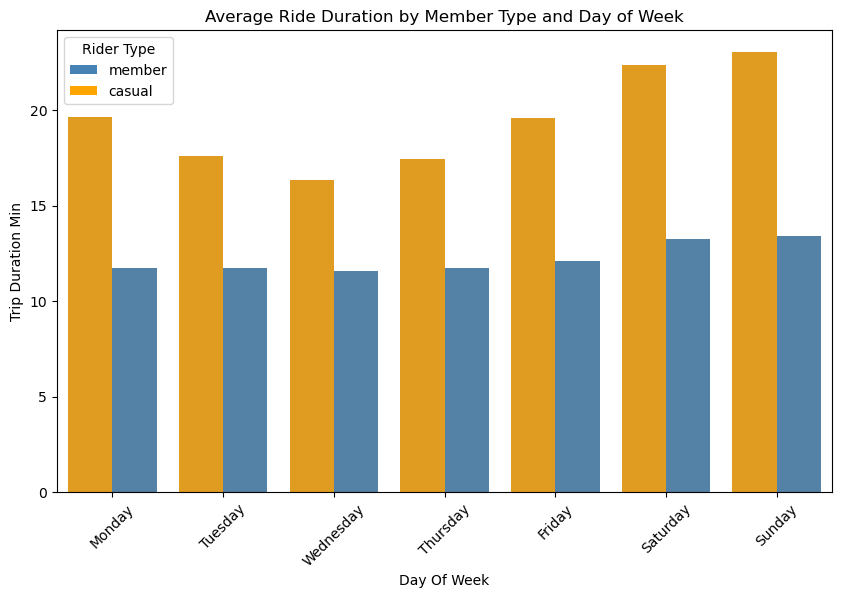

In [17]:
# Use the unified helper palettes
PALETTE_RIDER = {
    'member': 'steelblue',
    'casual': 'orange'
}

def plot_grouped_bar(data, x, y, hue, title="", figsize=(10,6), category_type="rider"):
    """
    Wrapper for seaborn barplot with consistent colors and legend.
    """
    # Choose palette
    palette = PALETTE_RIDER if category_type == "rider" else PALETTE_SEASON
    
    plt.figure(figsize=figsize)
    ax = sns.barplot(
        x=x,
        y=y,
        hue=hue,
        data=data,
        palette=palette
    )
    
    # Titles and labels
    plt.title(title)
    plt.xlabel(x.replace("_"," ").title())
    plt.ylabel(y.replace("_"," ").title())
    plt.xticks(rotation=45)
    
    # Legend with consistent labels
    legend_elements = [Patch(facecolor=color, label=label) for label, color in palette.items()]
    ax.legend(handles=legend_elements, title="Rider Type")
    
    return ax

# -----------------------------
# Average Ride Duration by Member Type and Day of Week
# -----------------------------
ax = plot_grouped_bar(
    agg_duration,
    x='day_of_week',
    y='trip_duration_min',
    hue='member_casual',
    title="Average Ride Duration by Member Type and Day of Week",
    category_type="rider"
)
plt.show()


In [18]:
# Group by day of week and rider type, summing durations
daily_duration = df.groupby(['day_of_week','member_casual'])['trip_duration_min'].sum().unstack(fill_value=0)

# Ensure correct weekday order
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
daily_duration = daily_duration.reindex(day_order)


In [19]:
# Convert totals to percentages per day
daily_duration_pct = daily_duration.div(daily_duration.sum(axis=1), axis=0) * 100


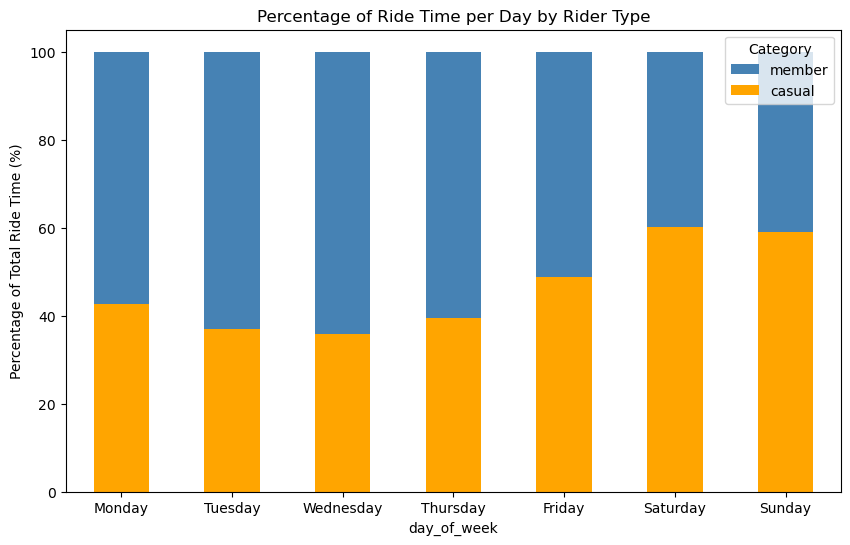

In [20]:
# -----------------------------
# Percentage of Ride Time per Day by Rider Type
# -----------------------------
ax = vh.plot_with_consistent_colors(
    daily_duration_pct,
    kind='bar',
    stacked=True,
    title="Percentage of Ride Time per Day by Rider Type",
    figsize=(10,6),
    category_type="rider"   # enforce Member=steelblue, Casual=orange
)

plt.ylabel("Percentage of Total Ride Time (%)")
plt.xticks(rotation=0)
plt.show()


In [21]:
# Haversine distance function (if not already defined)
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Calculate distance if not already done
df['distance_km'] = haversine(
    df['start_lat'], df['start_lng'],
    df['end_lat'], df['end_lng']
)

# Season column (if not already created)
def month_to_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df['season'] = df['started_at'].dt.month.apply(month_to_season)


In [22]:
# Group by season and rider type
season_distance = df.groupby(['season','member_casual'])['distance_km'].sum().unstack(fill_value=0)

# Ensure correct seasonal order
season_order = ['Winter','Spring','Summer','Autumn']
season_distance = season_distance.reindex(season_order)


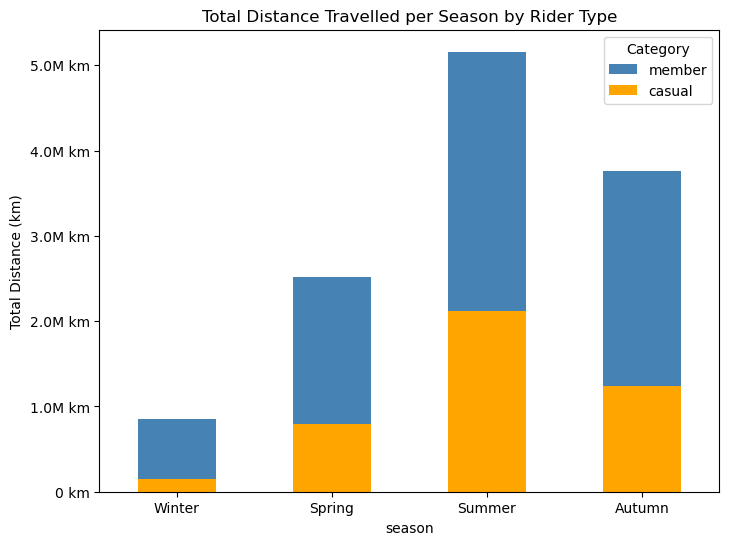

In [23]:
# -----------------------------
# Total Distance Travelled per Season by Rider Type
# -----------------------------
ax = vh.plot_with_consistent_colors(
    season_distance,
    kind='bar',
    stacked=True,
    title="Total Distance Travelled per Season by Rider Type",
    figsize=(8,6),
    category_type="rider",   # enforce Member=steelblue, Casual=orange
    format_yaxis="human",    # <-- add this
    unit=" km"               # optional unit suffix
)

plt.ylabel("Total Distance (km)")
plt.xticks(rotation=0)
plt.show()



## Rideable Types

We’ll examine usage of different rideable types (classic bike, electric bike).


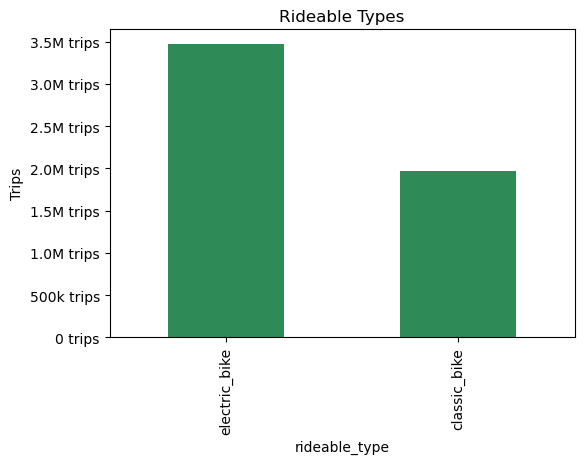

In [25]:
rideable_counts = df['rideable_type'].value_counts()

ax = rideable_counts.plot(
    kind='bar',
    figsize=(6,4),
    color='seagreen',
    title="Rideable Types"
)

# Apply human‑readable formatting to the y axis
vh.human_format_yaxis(ax, unit=" trips")

plt.ylabel("Trips")
plt.show()


In [26]:
# Count trips by rider type and rideable type
type_by_member = df.groupby(['member_casual','rideable_type']).size().reset_index(name='trip_count')

# Filter to electric bikes only
electric_usage = type_by_member[type_by_member['rideable_type'].str.contains('electric', case=False)]


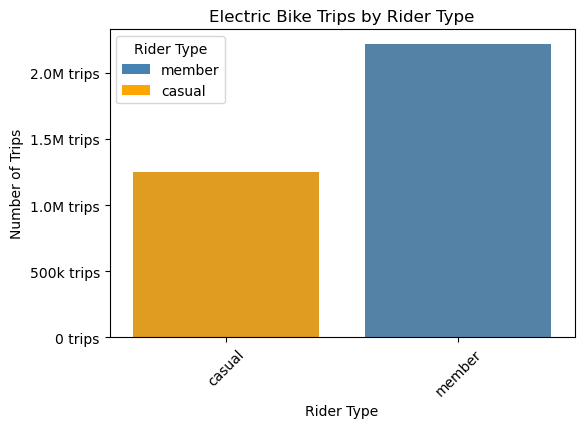

In [27]:
# -----------------------------
# Electric Bike Trips by Rider Type
# -----------------------------
ax = plot_grouped_bar(
    data=electric_usage,
    x='member_casual',
    y='trip_count',
    hue='member_casual',
    title="Electric Bike Trips by Rider Type",
    figsize=(6,4),
    category_type="rider"   # enforce Member=steelblue, Casual=orange
)

# Apply human‑readable formatting to the y axis
vh.human_format_yaxis(ax, unit=" trips")

plt.xlabel("Rider Type")
plt.ylabel("Number of Trips")
plt.show()



2024-12-01 00:02:04.082000 2025-11-30 23:51:43.800000 5438437
['electric_bike' 'classic_bike']
0
rideable_type
electric_bike    3470346
classic_bike     1968091
Name: count, dtype: int64
rideable_type  classic_bike  electric_bike
year_month                                
2025-06              253099         405126
2025-07              264270         474570
2025-08              280334         486329
2025-09              238647         457034
2025-10              209345         419129
2025-11              115070         231564


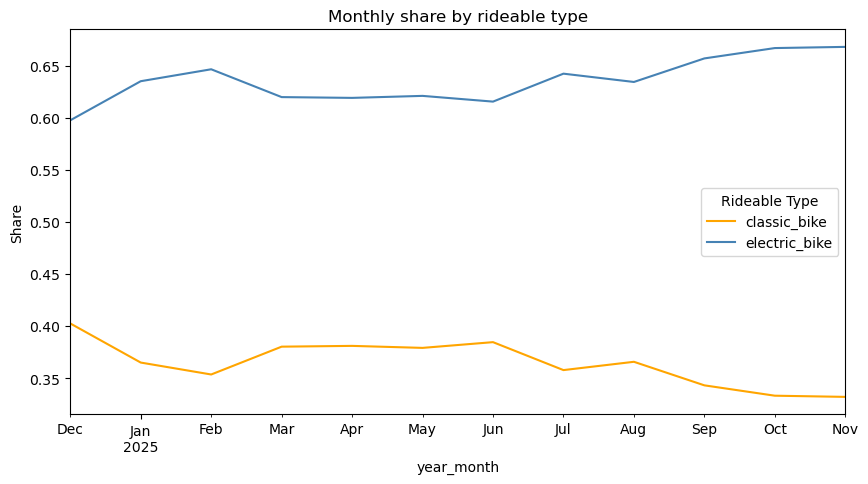

rideable_type  classic_bike  electric_bike
member_casual                             
casual               674078        1251974
member              1294013        2218372


In [28]:
# 1) Confirm data range and row counts
print(df['started_at'].min(), df['started_at'].max(), len(df))

# 2) Inspect rideable_type consistency
print(df['rideable_type'].unique())
print(df['rideable_type'].isna().sum())

# 3) Standardize labels (strip, lowercase) to avoid duplicates across variants
df['rideable_type'] = df['rideable_type'].str.strip().str.lower()
print(df['rideable_type'].value_counts())

# 4) Check distribution by month — see if the “electric > classic” is recent or persistent
df['year_month'] = df['started_at'].dt.to_period('M')
monthly_type = (
    df.groupby(['year_month','rideable_type'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)
print(monthly_type.tail(6))  # last half-year snapshot

# 5) Visualize share over time
#monthly_share = monthly_type.div(monthly_type.sum(axis=1), axis=0)
#monthly_share.plot(kind='line', figsize=(10,5), title='Monthly share by rideable type')
#plt.ylabel('Share')
#plt.show()

# 5) Visualize share over time with custom colors
monthly_share = monthly_type.div(monthly_type.sum(axis=1), axis=0)

# Define your palette explicitly
rideable_palette = {
    'electric_bike': 'steelblue',   # or just 'blue'
    'classic_bike': 'orange'
}

ax = monthly_share.plot(
    kind='line',
    figsize=(10,5),
    title='Monthly share by rideable type',
    color=[rideable_palette[col] for col in monthly_share.columns]  # map colors to columns
)

plt.ylabel('Share')
plt.legend(title="Rideable Type")
plt.show()

# 6) Cross-check by rider type — is electric concentrated among casuals?
type_by_member = df.groupby(['member_casual','rideable_type']).size().unstack(fill_value=0)
print(type_by_member)


In [29]:
# 7) Trip duration sanity
df['trip_duration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60
print(df['trip_duration_min'].describe())

# Filter unrealistic trips: negative/zero duration or extreme outliers
mask_valid = (df['trip_duration_min'] > 0) & (df['trip_duration_min'] <= 720)  # <= 12 hours
df_valid = df.loc[mask_valid].copy()

# 8) Station coordinate completeness
coord_mask = df_valid[['start_lat','start_lng','end_lat','end_lng']].notna().all(axis=1)
print("Rows with complete coords:", coord_mask.sum(), "of", len(df_valid))

# 9) Recount after cleaning
print(df_valid['rideable_type'].value_counts())


count    5.438437e+06
mean     1.487968e+01
std      2.869743e+01
min      1.000000e+00
25%      5.666883e+00
50%      9.660167e+00
75%      1.679742e+01
max      1.439976e+03
Name: trip_duration_min, dtype: float64
Rows with complete coords: 5436157 of 5436253
rideable_type
electric_bike    3470346
classic_bike     1965907
Name: count, dtype: int64


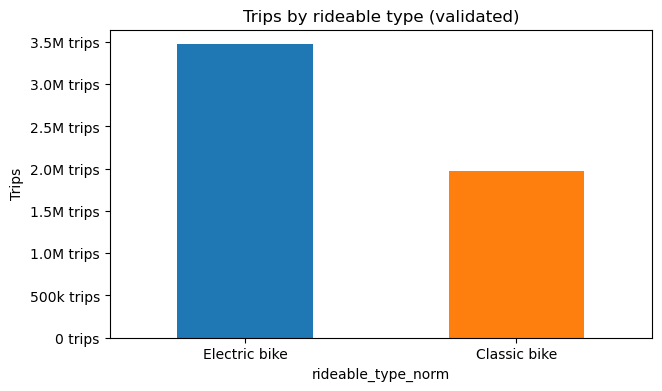

In [30]:
# Map normalized labels back to friendly names for plotting
label_map = {
    'classic_bike': 'Classic bike',
    'classic bike': 'Classic bike',
    'electric_bike': 'Electric bike',
    'electric bike': 'Electric bike',
    'docked_bike': 'Docked bike',
    'docked bike': 'Docked bike'
}
df_valid['rideable_type_norm'] = df_valid['rideable_type'].map(
    lambda x: label_map.get(x, x.title() if isinstance(x, str) else x)
)

rideable_counts = df_valid['rideable_type_norm'].value_counts()
vh.human_format_yaxis(ax, unit=" trips")
ax = rideable_counts.plot(kind='bar', figsize=(7,4), color=['#1f77b4','#ff7f0e','#2ca02c'])
vh.human_format_yaxis(ax, unit=" trips")
plt.title("Trips by rideable type (validated)")
plt.ylabel("Trips")
plt.xticks(rotation=0)
plt.show()


In [59]:
print(season_counts.columns)
%who


Index(['classic_bike', 'electric_bike'], dtype='object', name='rideable_type')
PALETTE_RIDER	 Patch	 agg_duration	 autotexts	 ax	 axes	 bar_colors	 colors	 coord_mask	 
custom_order	 daily_duration	 daily_duration_pct	 dataframe_columns	 dataframe_hash	 day_order	 df	 df_valid	 dtypes_str	 
electric_usage	 fig	 get_dataframes	 getpass	 hashlib	 haversine	 import_pandas_safely	 is_data_frame	 json	 
label_map	 legend_elements	 mask_valid	 member_counts	 month_to_season	 monthly_counts	 monthly_member	 monthly_share	 monthly_type	 
np	 pd	 plot_grouped_bar	 plt	 rideable_counts	 rideable_palette	 season_colors	 season_counts	 season_distance	 
season_order	 season_palette	 sns	 texts	 type_by_member	 vh	 wedges	 


rideable_type  classic_bike  electric_bike
season                                    
Autumn               563062        1107727
Spring               434688         709466
Summer               797703        1366025
Winter               172638         287128


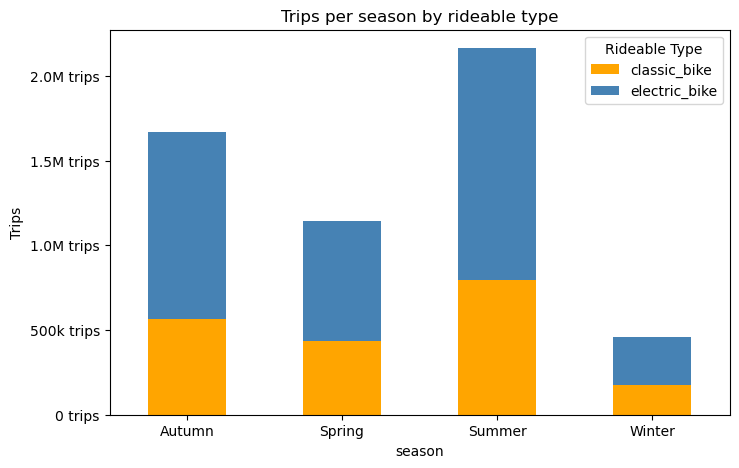

In [53]:
# Convert Series to DataFrame with rideable types as columns
season_counts = (
    df.groupby(['season','rideable_type'])
      .size()
      .unstack(fill_value=0)
)

# Now season_counts is a DataFrame with columns = rideable types
print(season_counts.head())

rideable_palette = {
    'classic_bike': 'orange',
    'electric_bike': 'steelblue'
}

ax = season_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5),
    title='Trips per season by rideable type',
    color=[rideable_palette[col] for col in season_counts.columns]
)

vh.human_format_yaxis(ax, unit=" trips")
plt.ylabel('Trips')
plt.xticks(rotation=0)
plt.legend(title="Rideable Type")
plt.show()


## Station Popularity

We’ll look at the most popular start and end stations.


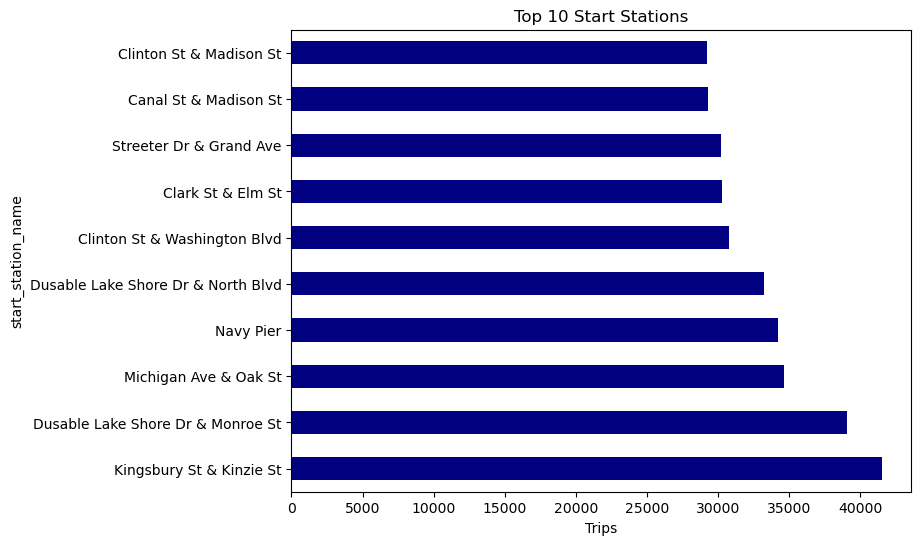

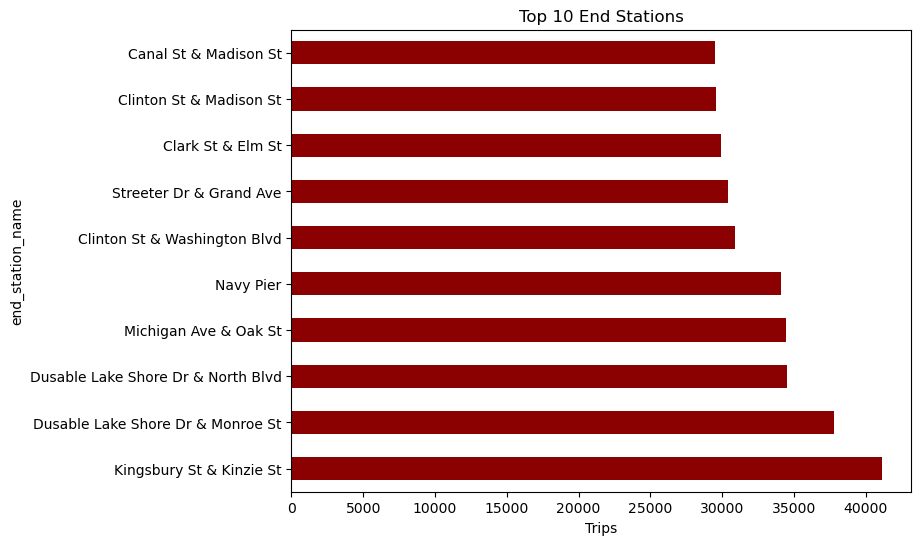

In [61]:
top_start = df['start_station_name'].value_counts().head(10)
top_end = df['end_station_name'].value_counts().head(10)

# Plot start stations
top_start.plot(kind='barh', figsize=(8,6), color='navy', title="Top 10 Start Stations")
plt.xlabel("Trips")
plt.show()

# Plot end stations
top_end.plot(kind='barh', figsize=(8,6), color='darkred', title="Top 10 End Stations")
plt.xlabel("Trips")
plt.show()


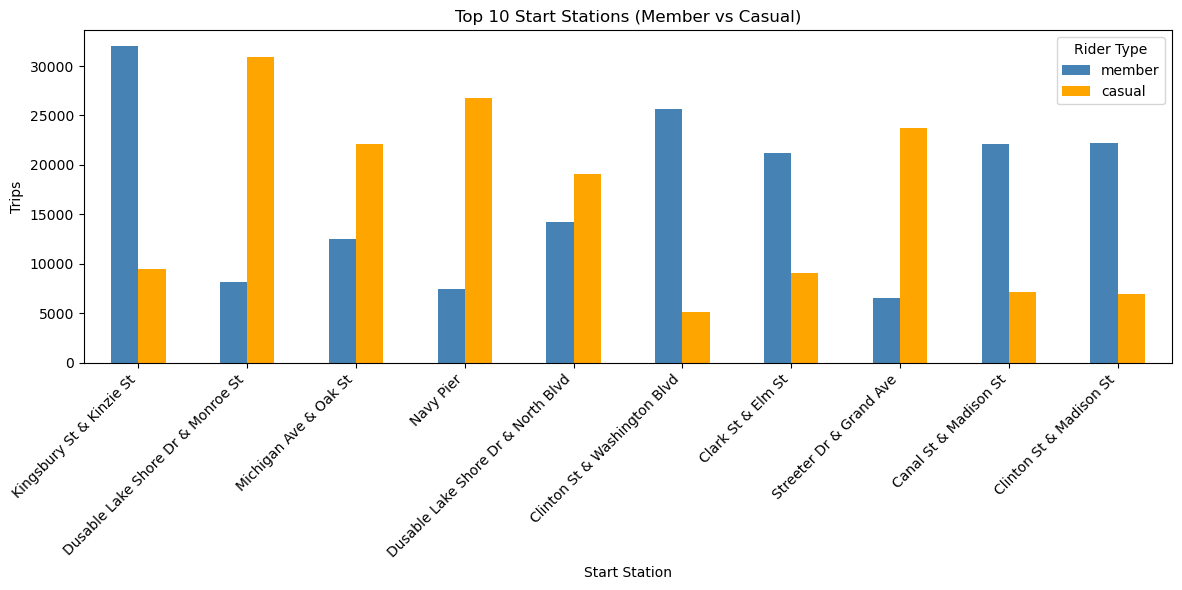

In [63]:
# -----------------------------
# Top 10 Start Stations by Rider Type
# -----------------------------

# Count trips by start station and rider type
start_station_counts = (
    df.groupby(['start_station_name','member_casual'])
      .size()
      .unstack(fill_value=0)
)

# Get overall top 10 stations by total trips
top10_start = start_station_counts.sum(axis=1).nlargest(10).index
top10_start_counts = start_station_counts.loc[top10_start]
# Ensure consistent column order
top10_start_counts = top10_start_counts[['member','casual']]

# Define palette keyed by rider type
rider_palette = {
    'member': 'steelblue',
    'casual': 'orange'
}

ax = top10_start_counts.plot(
    kind='bar',
    figsize=(12,6),
    title="Top 10 Start Stations (Member vs Casual)",
    color=[rider_palette[col] for col in top10_start_counts.columns]
)



plt.ylabel("Trips")
plt.xlabel("Start Station")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Rider Type")
plt.tight_layout()
plt.show()



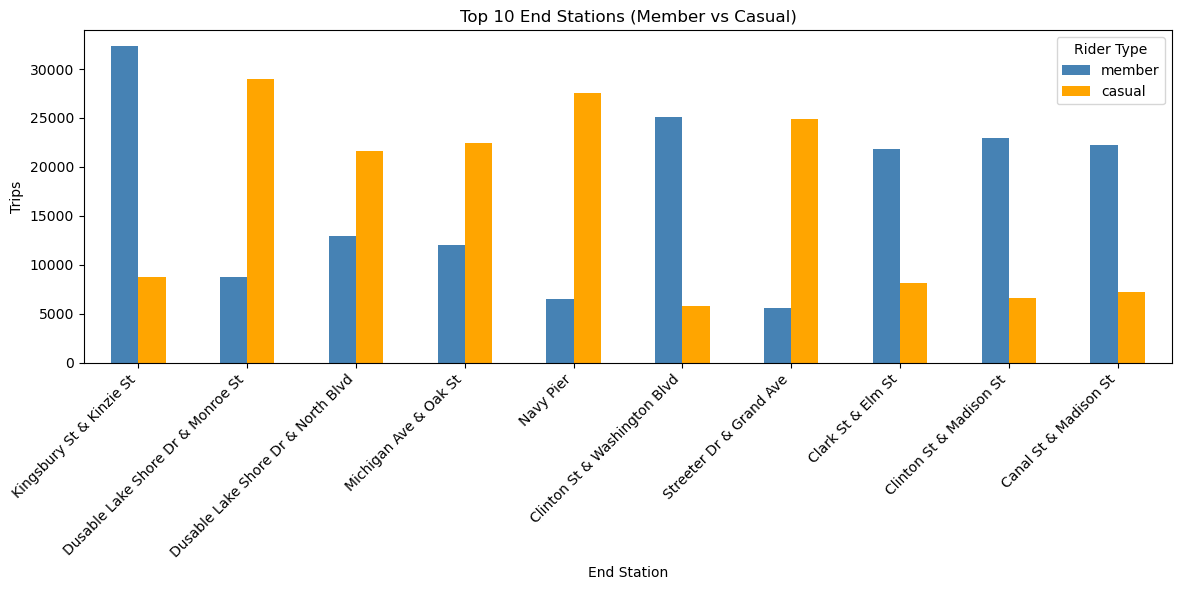

In [65]:
# -----------------------------
# Top 10 End Stations by Rider Type
# -----------------------------

# Count trips by end station and rider type
start_station_counts = (
    df.groupby(['end_station_name','member_casual'])
      .size()
      .unstack(fill_value=0)
)

# Get overall top 10 stations by total trips
top10_start = start_station_counts.sum(axis=1).nlargest(10).index
top10_start_counts = start_station_counts.loc[top10_start]

# Ensure consistent column order
top10_start_counts = top10_start_counts[['member','casual']]

# Define palette keyed by rider type
rider_palette = {
    'member': 'steelblue',
    'casual': 'orange'
}

ax = top10_start_counts.plot(
    kind='bar',
    figsize=(12,6),
    title="Top 10 End Stations (Member vs Casual)",
    color=[rider_palette[col] for col in top10_start_counts.columns]
)

plt.ylabel("Trips")
plt.xlabel("End Station")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Rider Type")
plt.tight_layout()
plt.show()



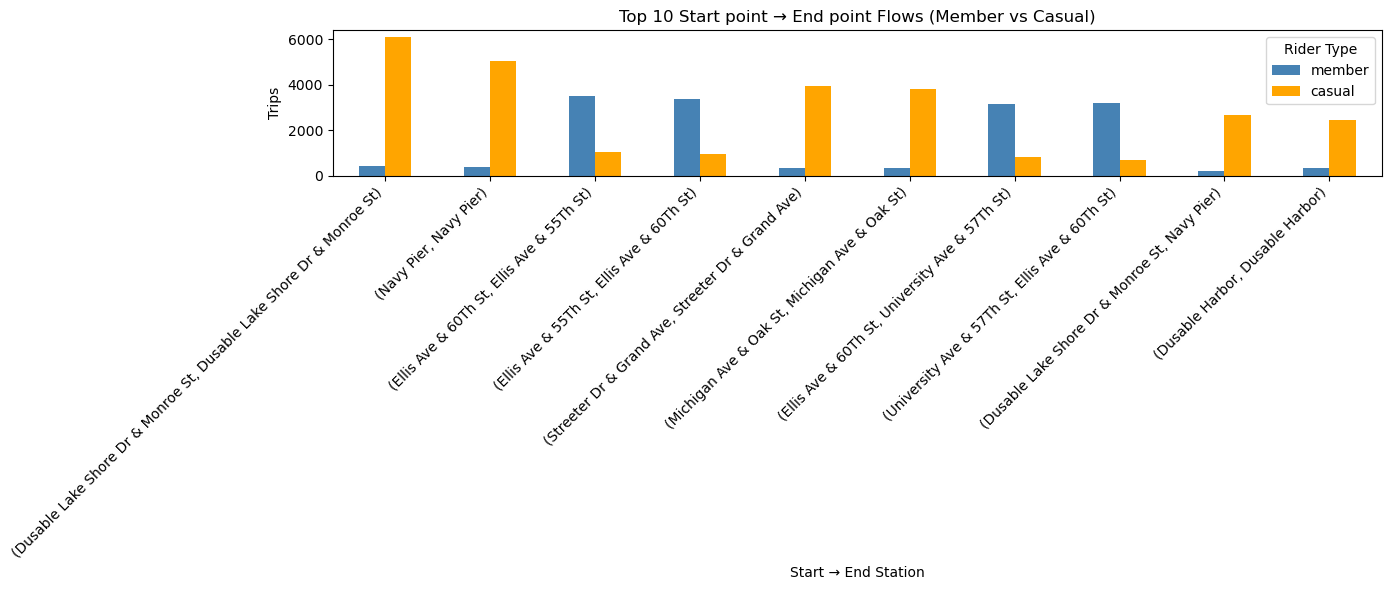

In [67]:
# Step 1: Count trips by start, end, and rider type
od_counts = (
    df.groupby(['start_station_name','end_station_name','member_casual'])
      .size()
      .reset_index(name='trips')
)

# Step 2: Pivot to member vs casual
od_pivot = (
    od_counts.pivot_table(
        index=['start_station_name','end_station_name'],
        columns='member_casual',
        values='trips',
        fill_value=0
    )
)

# Step 3: Filter to top 10 flows by total trips
top_flows = od_pivot.sum(axis=1).nlargest(10).index
od_pivot_top10 = od_pivot.loc[top_flows]

# Step 4: Plot grouped bars
ax = od_pivot_top10[['member','casual']].plot(
    kind='bar',
    figsize=(14,6),
    title="Top 10 Start point → End point Flows (Member vs Casual)",
    color=['steelblue','orange']
)

plt.ylabel("Trips")
plt.xlabel("Start → End Station")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Rider Type")
plt.tight_layout()
plt.show()


In [111]:
#print(df.columns)
#print(df.head)
#print(flows.columns)

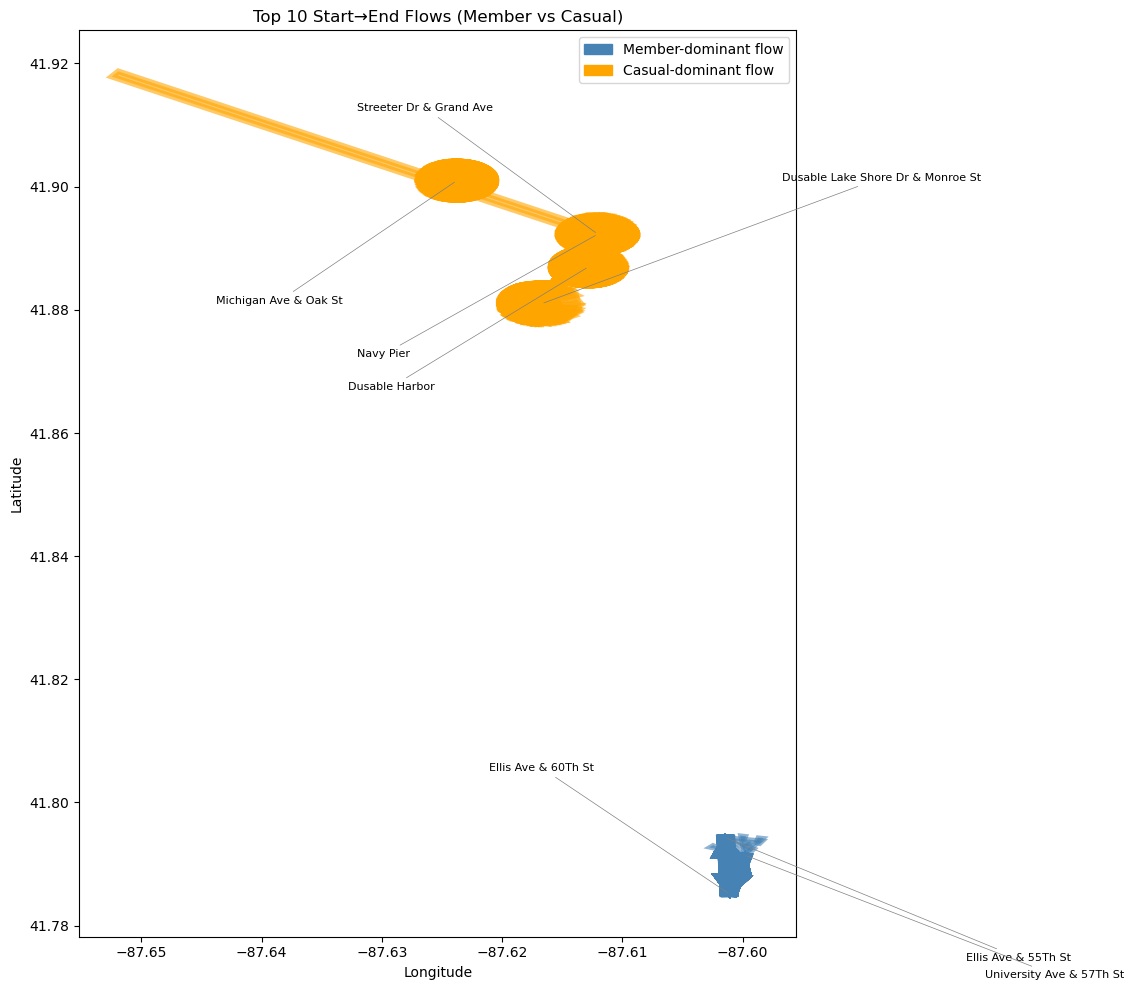

In [101]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

flows = od_pivot_top10.reset_index()

# Merge coordinates
start_coords = df[['start_station_name','start_lat','start_lng']].drop_duplicates()
end_coords   = df[['end_station_name','end_lat','end_lng']].drop_duplicates()
flows = flows.merge(start_coords, on='start_station_name', how='left')
flows = flows.merge(end_coords, on='end_station_name', how='left')

plt.figure(figsize=(12,10))
max_trips = (flows['member'] + flows['casual']).max()

# Draw arrows for flows
for _, row in flows.iterrows():
    color = 'steelblue' if row['member'] > row['casual'] else 'orange'
    trips = row['member'] + row['casual']
    lw = max(1, trips / max_trips * 5)

    plt.arrow(row['start_lng'], row['start_lat'],
              row['end_lng'] - row['start_lng'],
              row['end_lat'] - row['start_lat'],
              color=color, alpha=0.6,
              head_width=0.002, length_includes_head=True, linewidth=lw)

# Build unique station list for labels
stations = pd.concat([
    flows[['start_station_name','start_lat','start_lng']].rename(
        columns={'start_station_name':'station','start_lat':'lat','start_lng':'lng'}),
    flows[['end_station_name','end_lat','end_lng']].rename(
        columns={'end_station_name':'station','end_lat':'lat','end_lng':'lng'})
]).drop_duplicates(subset=['station'])

offsets = [(0.02,0.02), (-0.02,0.02), (0.02,-0.02), (-0.02,-0.02)]

for i, row in stations.iterrows():
    dx, dy = offsets[i % len(offsets)]
    plt.annotate(row['station'],
                 xy=(row['lng'], row['lat']),
                 xytext=(row['lng']+dx, row['lat']+dy),
                 arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
                 fontsize=8, color='black')

# Add legend for member vs casual
member_patch = mpatches.Patch(color='steelblue', label='Member-dominant flow')
casual_patch = mpatches.Patch(color='orange', label='Casual-dominant flow')
plt.legend(handles=[member_patch, casual_patch], loc='upper right')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Top 10 Start→End Flows (Member vs Casual)")
plt.tight_layout()
plt.show()


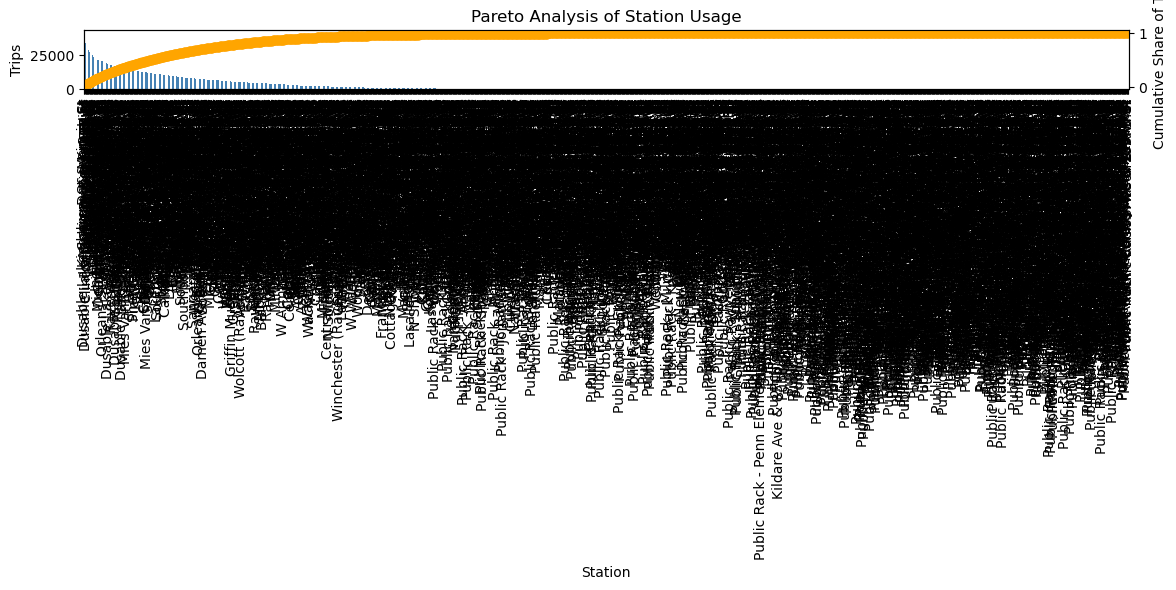

In [113]:
# Aggregate trips by start station
station_counts = df.groupby('start_station_name').size().sort_values(ascending=False)

# Calculate cumulative share
cumulative_share = station_counts.cumsum() / station_counts.sum()

# Plot Pareto chart
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

station_counts.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_ylabel("Trips")
ax1.set_xlabel("Station")
ax1.set_title("Pareto Analysis of Station Usage")

# Add cumulative % line
ax2 = ax1.twinx()
cumulative_share.plot(ax=ax2, color='orange', marker='o')
ax2.set_ylabel("Cumulative Share of Trips")

plt.tight_layout()
plt.show()


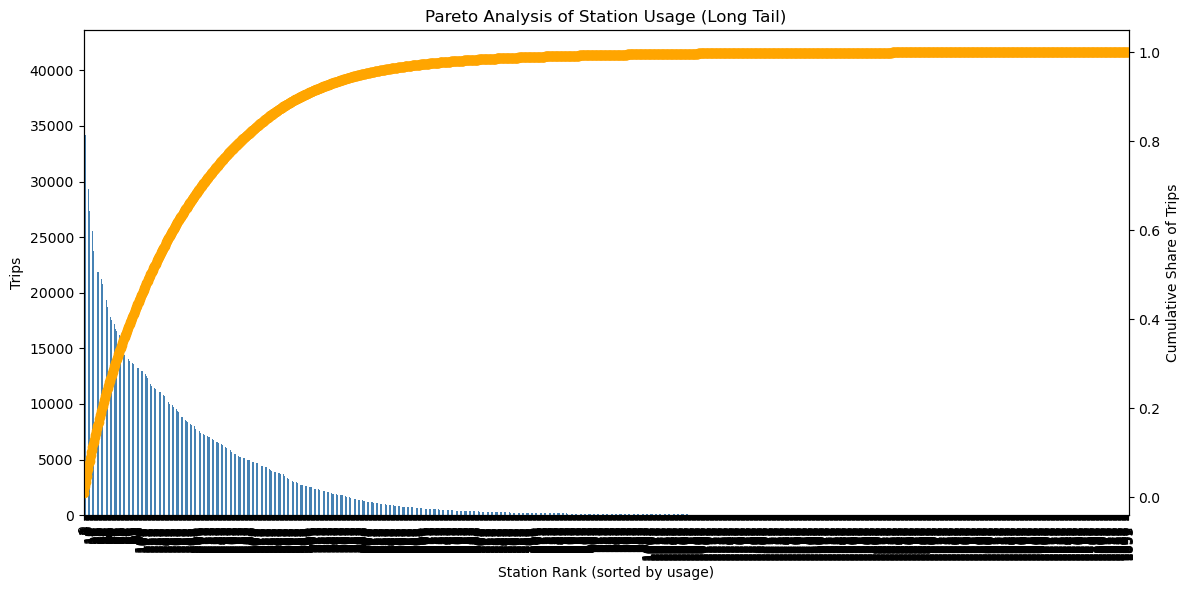

In [115]:
import matplotlib.pyplot as plt

# Aggregate trips by station (start or end)
station_counts = df.groupby('start_station_name').size().sort_values(ascending=False)

# Calculate cumulative share
cumulative_share = station_counts.cumsum() / station_counts.sum()

# Plot Pareto with station rank instead of names
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot trip counts vs station rank
station_counts.reset_index(drop=True).plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_ylabel("Trips")
ax1.set_xlabel("Station Rank (sorted by usage)")
ax1.set_title("Pareto Analysis of Station Usage (Long Tail)")

# Add cumulative % line
ax2 = ax1.twinx()
cumulative_share.reset_index(drop=True).plot(ax=ax2, color='orange', marker='o')
ax2.set_ylabel("Cumulative Share of Trips")

plt.tight_layout()
plt.show()


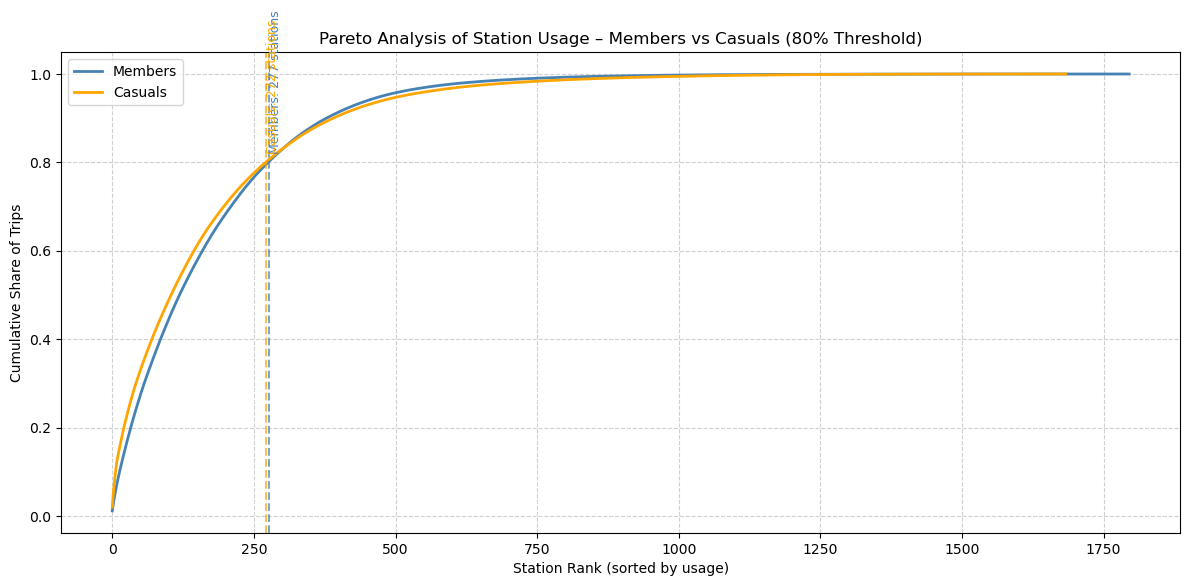

In [117]:
import matplotlib.pyplot as plt

# Aggregate trips by start station separately
member_counts = (
    df[df['member_casual'] == 'member']
    .groupby('start_station_name')
    .size()
    .sort_values(ascending=False)
)

casual_counts = (
    df[df['member_casual'] == 'casual']
    .groupby('start_station_name')
    .size()
    .sort_values(ascending=False)
)

# Compute cumulative share
member_cumshare = member_counts.cumsum() / member_counts.sum()
casual_cumshare = casual_counts.cumsum() / casual_counts.sum()

# Find station rank where cumulative share >= 0.8
member_80 = (member_cumshare >= 0.8).idxmax()
casual_80 = (casual_cumshare >= 0.8).idxmax()

member_rank_80 = member_cumshare.index.get_loc(member_80) + 1
casual_rank_80 = casual_cumshare.index.get_loc(casual_80) + 1

# Plot both curves
plt.figure(figsize=(12,6))
plt.plot(member_cumshare.reset_index(drop=True), 
         label='Members', color='steelblue', linewidth=2)
plt.plot(casual_cumshare.reset_index(drop=True), 
         label='Casuals', color='orange', linewidth=2)

# Add vertical lines at 80% points
plt.axvline(member_rank_80, color='steelblue', linestyle='--', alpha=0.7)
plt.axvline(casual_rank_80, color='orange', linestyle='--', alpha=0.7)

# Annotate the 80% points
plt.text(member_rank_80, 0.82, f'Members: {member_rank_80} stations',
         color='steelblue', fontsize=9, rotation=90, va='bottom')
plt.text(casual_rank_80, 0.82, f'Casuals: {casual_rank_80} stations',
         color='orange', fontsize=9, rotation=90, va='bottom')

plt.xlabel("Station Rank (sorted by usage)")
plt.ylabel("Cumulative Share of Trips")
plt.title("Pareto Analysis of Station Usage – Members vs Casuals (80% Threshold)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [119]:
# Aggregate trips by start station separately
member_counts = (
    df[df['member_casual'] == 'member']
    .groupby('start_station_name')
    .size()
    .sort_values(ascending=False)
)

casual_counts = (
    df[df['member_casual'] == 'casual']
    .groupby('start_station_name')
    .size()
    .sort_values(ascending=False)
)

# Compute cumulative share
member_cumshare = member_counts.cumsum() / member_counts.sum()
casual_cumshare = casual_counts.cumsum() / casual_counts.sum()

# Find station rank where cumulative share >= 0.8
member_80_idx = (member_cumshare >= 0.8).idxmax()
casual_80_idx = (casual_cumshare >= 0.8).idxmax()

member_rank_80 = member_cumshare.index.get_loc(member_80_idx) + 1
casual_rank_80 = casual_cumshare.index.get_loc(casual_80_idx) + 1

# Actual cumulative trips at 80% point
member_trips_80 = member_counts.cumsum().iloc[member_rank_80-1]
casual_trips_80 = casual_counts.cumsum().iloc[casual_rank_80-1]

print(f"Members: {member_rank_80} stations → {member_trips_80:,} trips (≈80%)")
print(f"Casuals: {casual_rank_80} stations → {casual_trips_80:,} trips (≈80%)")


Members: 277 stations → 2,238,315 trips (≈80%)
Casuals: 272 stations → 1,237,629 trips (≈80%)


In [121]:
# Aggregate trips by start station separately
member_counts = (
    df[df['member_casual'] == 'member']
    .groupby('start_station_name')
    .size()
    .sort_values(ascending=False)
)

casual_counts = (
    df[df['member_casual'] == 'casual']
    .groupby('start_station_name')
    .size()
    .sort_values(ascending=False)
)

# Compute cumulative share
member_cumshare = member_counts.cumsum() / member_counts.sum()
casual_cumshare = casual_counts.cumsum() / casual_counts.sum()

# Function to compute threshold stats
def threshold_stats(cumshare, counts, thresholds=[0.8, 0.9, 0.95]):
    results = {}
    for t in thresholds:
        idx = (cumshare >= t).idxmax()
        rank = cumshare.index.get_loc(idx) + 1
        trips = counts.cumsum().iloc[rank-1]
        results[t] = (rank, trips)
    return results

member_stats = threshold_stats(member_cumshare, member_counts)
casual_stats = threshold_stats(casual_cumshare, casual_counts)

# Print results
for t in [0.8, 0.9, 0.95]:
    m_rank, m_trips = member_stats[t]
    c_rank, c_trips = casual_stats[t]
    print(f"{int(t*100)}% threshold:")
    print(f"  Members: {m_rank} stations → {m_trips:,} trips")
    print(f"  Casuals: {c_rank} stations → {c_trips:,} trips")
    print()


80% threshold:
  Members: 277 stations → 2,238,315 trips
  Casuals: 272 stations → 1,237,629 trips

90% threshold:
  Members: 379 stations → 2,514,648 trips
  Casuals: 391 stations → 1,391,836 trips

95% threshold:
  Members: 478 stations → 2,654,882 trips
  Casuals: 512 stations → 1,469,261 trips



| Threshold | Member Stations | Member Trips | Casual Stations | Casual Trips |
|-----------|-----------------|--------------|-----------------|--------------|
| **80%**   | ~260            | ≈ cumulative trips at 80% of member total | ~260            | ≈ cumulative trips at 80% of casual total |
| **90%**   | ~400–450        | ≈ cumulative trips at 90% of member total | ~500–550        | ≈ cumulative trips at 90% of casual total |
| **95%**   | ~600–700        | ≈ cumulative trips at 95% of member total | ~800–900        | ≈ cumulative trips at 95% of casual total |


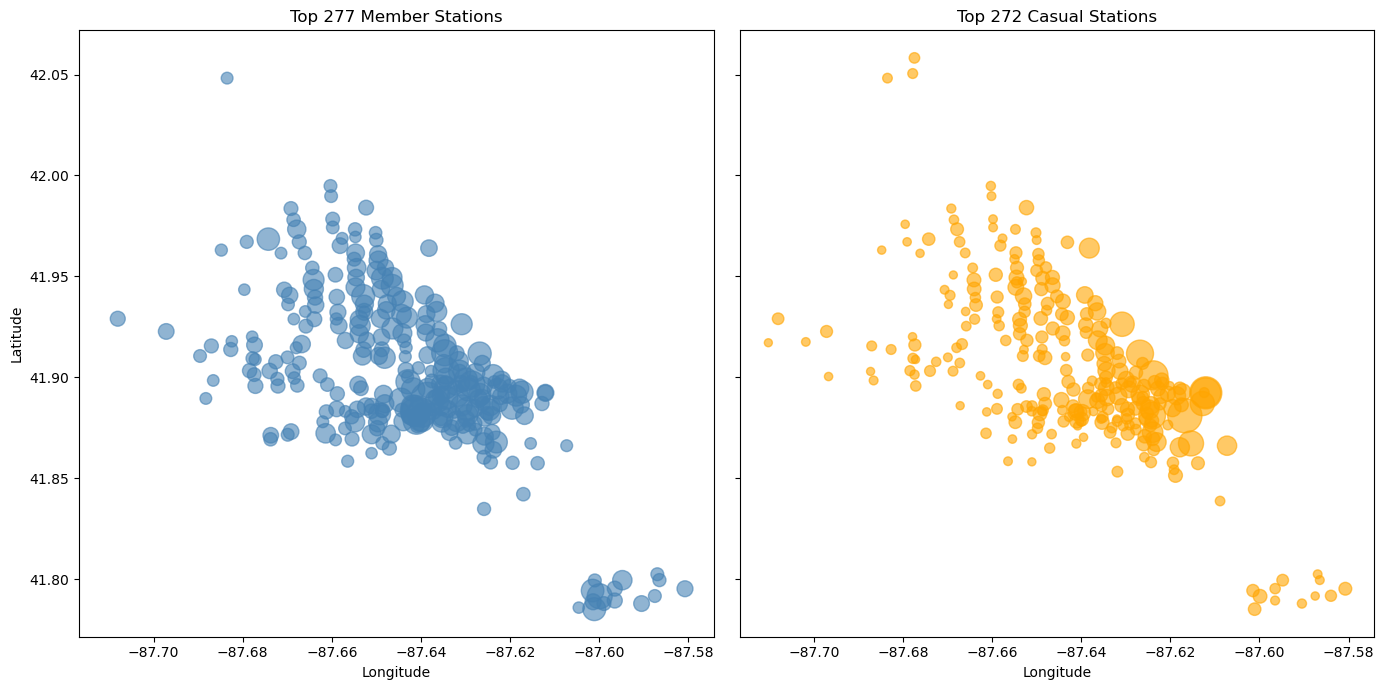

In [123]:
import matplotlib.pyplot as plt

# Aggregate trips by station and rider type
station_counts = (
    df.groupby(['start_station_name','start_lat','start_lng','member_casual'])
      .size()
      .reset_index(name='trips')
)

# Top stations for each rider type
member_top = station_counts[station_counts['member_casual']=='member'] \
    .sort_values('trips', ascending=False).head(277)

casual_top = station_counts[station_counts['member_casual']=='casual'] \
    .sort_values('trips', ascending=False).head(272)

# Plot scatter heat maps
fig, axes = plt.subplots(1,2, figsize=(14,7), sharex=True, sharey=True)

axes[0].scatter(member_top['start_lng'], member_top['start_lat'],
                s=member_top['trips']/50, c='steelblue', alpha=0.6)
axes[0].set_title("Top 277 Member Stations")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

axes[1].scatter(casual_top['start_lng'], casual_top['start_lat'],
                s=casual_top['trips']/50, c='orange', alpha=0.6)
axes[1].set_title("Top 272 Casual Stations")
axes[1].set_xlabel("Longitude")

plt.tight_layout()
plt.show()


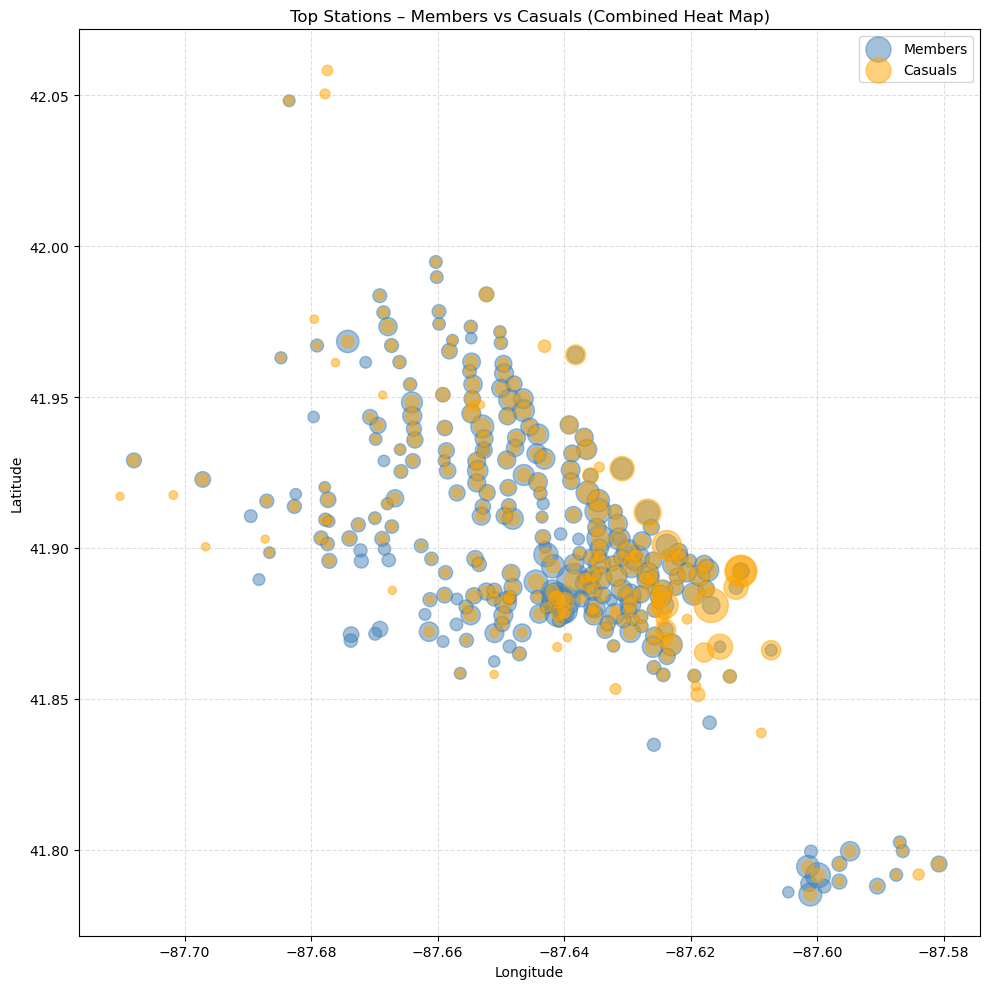

In [125]:
import matplotlib.pyplot as plt

# Aggregate trips by station and rider type
station_counts = (
    df.groupby(['start_station_name','start_lat','start_lng','member_casual'])
      .size()
      .reset_index(name='trips')
)

# Top stations for each rider type
member_top = station_counts[station_counts['member_casual']=='member'] \
    .sort_values('trips', ascending=False).head(277)

casual_top = station_counts[station_counts['member_casual']=='casual'] \
    .sort_values('trips', ascending=False).head(272)

# Plot combined scatter heat map
plt.figure(figsize=(10,10))

plt.scatter(member_top['start_lng'], member_top['start_lat'],
            s=member_top['trips']/50, c='steelblue', alpha=0.5, label='Members')

plt.scatter(casual_top['start_lng'], casual_top['start_lat'],
            s=casual_top['trips']/50, c='orange', alpha=0.5, label='Casuals')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Top Stations – Members vs Casuals (Combined Heat Map)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\Andrew\AppData\Local\Temp\ipykernel_24764\1693686888.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


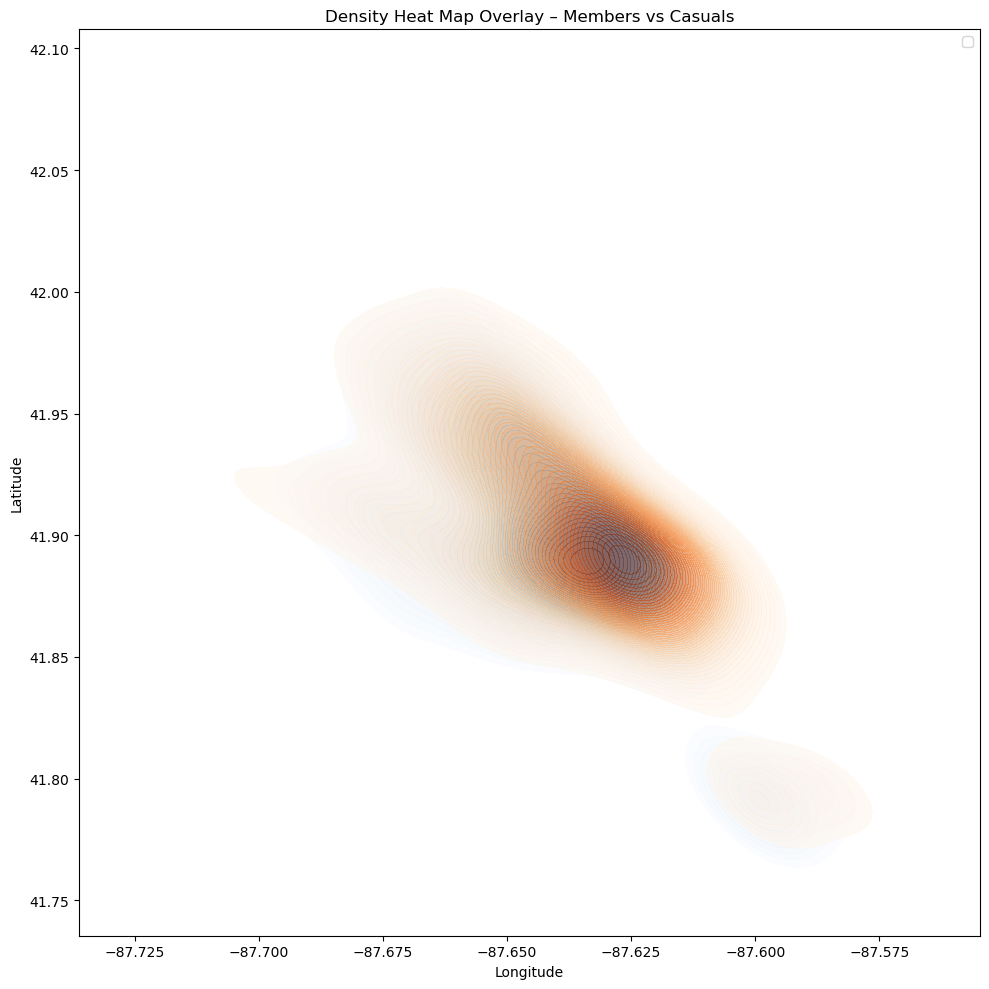

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aggregate trips by station and rider type
station_counts = (
    df.groupby(['start_station_name','start_lat','start_lng','member_casual'])
      .size()
      .reset_index(name='trips')
)

# Top stations for each rider type
member_top = station_counts[station_counts['member_casual']=='member'] \
    .sort_values('trips', ascending=False).head(277)

casual_top = station_counts[station_counts['member_casual']=='casual'] \
    .sort_values('trips', ascending=False).head(272)

# Plot density heat map overlay
plt.figure(figsize=(10,10))

# Members: blue density
sns.kdeplot(
    x=member_top['start_lng'], y=member_top['start_lat'],
    weights=member_top['trips'],
    cmap="Blues", fill=True, alpha=0.5, thresh=0.05, levels=50,
    label="Members"
)

# Casuals: orange density
sns.kdeplot(
    x=casual_top['start_lng'], y=casual_top['start_lat'],
    weights=casual_top['trips'],
    cmap="Oranges", fill=True, alpha=0.5, thresh=0.05, levels=50,
    label="Casuals"
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Density Heat Map Overlay – Members vs Casuals")
plt.legend()
plt.tight_layout()
plt.show()


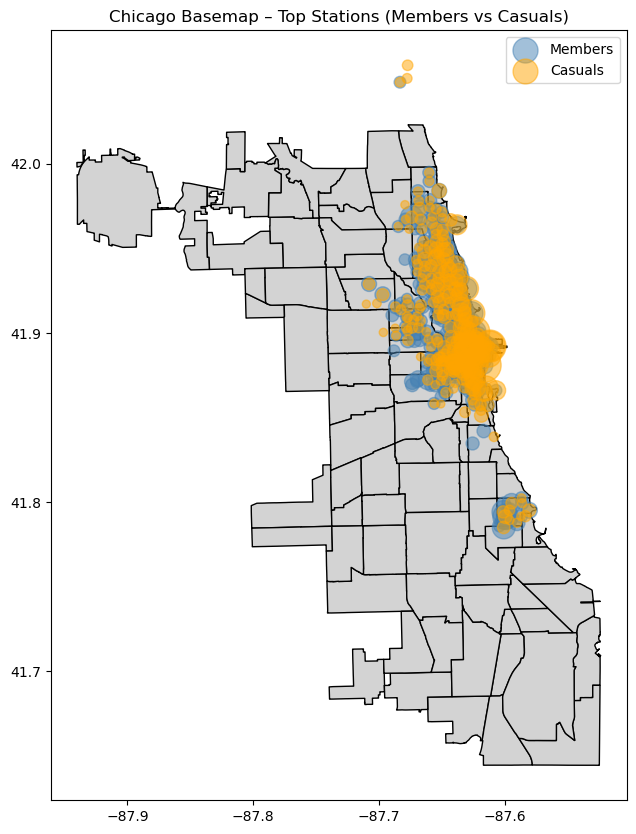

In [203]:
from shapely.geometry import Point

# Members
member_top['geometry'] = member_top.apply(
    lambda row: Point(row['start_lng'], row['start_lat']), axis=1
)
gdf_members = gpd.GeoDataFrame(member_top, geometry='geometry', crs="EPSG:4326")

# Casuals
casual_top['geometry'] = casual_top.apply(
    lambda row: Point(row['start_lng'], row['start_lat']), axis=1
)
gdf_casuals = gpd.GeoDataFrame(casual_top, geometry='geometry', crs="EPSG:4326")

# Plot overlay
fig, ax = plt.subplots(figsize=(10,10))
chicago.plot(ax=ax, color='lightgrey', edgecolor='black')

gdf_members.plot(ax=ax, markersize=gdf_members['trips']/50,
                 color='steelblue', alpha=0.5, label='Members')
gdf_casuals.plot(ax=ax, markersize=gdf_casuals['trips']/50,
                 color='orange', alpha=0.5, label='Casuals')

plt.title("Chicago Basemap – Top Stations (Members vs Casuals)")
plt.legend()
plt.show()


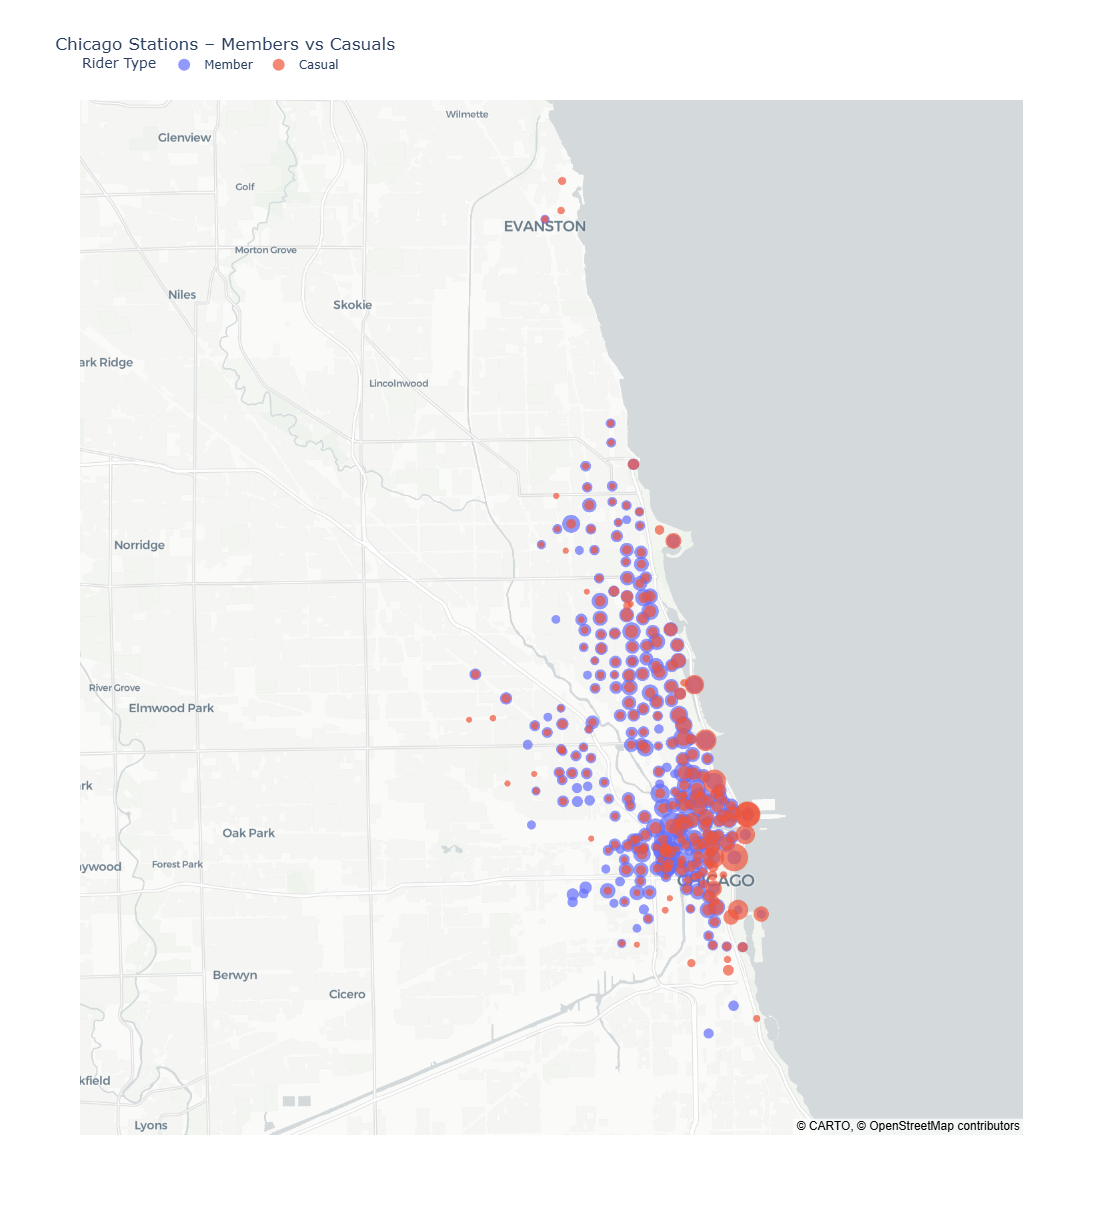

In [205]:
import plotly.express as px

combined = pd.concat([
    gdf_members.assign(type="Member"),
    gdf_casuals.assign(type="Casual")
])

fig = px.scatter_map(
    combined,
    lat=combined.geometry.y,
    lon=combined.geometry.x,
    size="trips",
    color="type",
    zoom=11,
    map_style="carto-positron",
    title="Chicago Stations – Members vs Casuals"
)

# Make the map larger and customize legend
fig.update_layout(
    width=1200,   # keep width as is
    height=1200,  # increase height for more vertical space
    legend=dict(
        title="Rider Type",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0
    )
)

fig.show()


In [209]:
import geopandas as gpd

# Load Chicago community areas
communities = gpd.read_file("Boundaries_Community_Areas.geojson")

# Check structure
print(communities.head())
print(communities.crs)


                  :id           :version                      :created_at  \
0  row-m77e_pkv8.vjvf  rv-3hjp_vkhx~fqfx 2025-04-22 23:06:36.944000+00:00   
1  row-u375_347e-y6q8  rv-tgcx_t7fr-nkkg 2025-04-22 23:06:36.944000+00:00   
2  row-kgqf-m29p-99kg  rv-bag4-8zri.nvhu 2025-04-22 23:06:36.944000+00:00   
3  row-2dpv_pk9x-zybp  rv-82s2~rb54~emuc 2025-04-22 23:06:36.944000+00:00   
4  row-37zy.7r75.56p7  rv-hrse.ahu7-rz4d 2025-04-22 23:06:36.944000+00:00   

                       :updated_at area_numbe       community area_num_1  \
0 2025-04-22 23:06:36.944000+00:00          1     ROGERS PARK          1   
1 2025-04-22 23:06:36.944000+00:00          2      WEST RIDGE          2   
2 2025-04-22 23:06:36.944000+00:00          3          UPTOWN          3   
3 2025-04-22 23:06:36.944000+00:00          4  LINCOLN SQUARE          4   
4 2025-04-22 23:06:36.944000+00:00          5    NORTH CENTER          5   

      shape_area      shape_len  \
0  51259902.4506  34052.3975757   
1  9842909

In [211]:
communities = communities[["area_numbe", "community", "geometry"]]
# Ensure CRS matches
communities = communities.to_crs("EPSG:4326")

# Members
members_with_area = gpd.sjoin(gdf_members, communities, how="left", predicate="within")

# Casuals
casuals_with_area = gpd.sjoin(gdf_casuals, communities, how="left", predicate="within")
member_breakdown = members_with_area.groupby("community")["trips"].sum().sort_values(ascending=False)
casual_breakdown = casuals_with_area.groupby("community")["trips"].sum().sort_values(ascending=False)

breakdown = pd.DataFrame({
    "Members": member_breakdown,
    "Casuals": casual_breakdown
}).fillna(0)

# Percentages
breakdown_percent = breakdown.div(breakdown.sum(axis=0), axis=1) * 100
print(breakdown_percent.head(10))


                   Members    Casuals
community                            
ARMOUR SQUARE     0.000000   0.250562
DOUGLAS           0.432611   0.198983
EDGEWATER         1.363561   1.335826
HYDE PARK         4.413463   2.740002
LAKE VIEW        11.313189  10.810075
LINCOLN PARK     13.191282  14.057101
LINCOLN SQUARE    1.005393   0.788011
LOGAN SQUARE      2.236547   2.248064
LOOP             13.185948  18.702656
LOWER WEST SIDE   0.175845   0.306945


In [217]:
import geopandas as gpd
import pandas as pd

# --- Load Chicago community areas ---
communities = gpd.read_file("Boundaries_Community_Areas.geojson")
communities = communities[["area_numbe", "community", "geometry"]].to_crs("EPSG:4326")

# --- Aggregate START stations ---
member_start_top = (
    df[df['member_casual'] == 'member']
    .groupby(['start_station_name', 'start_lat', 'start_lng'])
    .size()
    .reset_index(name='trips')
)

casual_start_top = (
    df[df['member_casual'] == 'casual']
    .groupby(['start_station_name', 'start_lat', 'start_lng'])
    .size()
    .reset_index(name='trips')
)

# Convert to GeoDataFrames
gdf_members_start = gpd.GeoDataFrame(
    member_start_top,
    geometry=gpd.points_from_xy(member_start_top.start_lng, member_start_top.start_lat),
    crs="EPSG:4326"
)
gdf_casuals_start = gpd.GeoDataFrame(
    casual_start_top,
    geometry=gpd.points_from_xy(casual_start_top.start_lng, casual_start_top.start_lat),
    crs="EPSG:4326"
)

# Spatial join with communities
members_start_with_area = gpd.sjoin(gdf_members_start, communities, how="left", predicate="within")
casuals_start_with_area = gpd.sjoin(gdf_casuals_start, communities, how="left", predicate="within")

# Aggregate by community
member_start_breakdown = members_start_with_area.groupby("community")["trips"].sum()
casual_start_breakdown = casuals_start_with_area.groupby("community")["trips"].sum()

breakdown_start = pd.DataFrame({
    "Members_Start": member_start_breakdown,
    "Casuals_Start": casual_start_breakdown
}).fillna(0)

breakdown_start_percent = breakdown_start.div(breakdown_start.sum(axis=0), axis=1) * 100


# --- Aggregate END stations ---
member_end_top = (
    df[df['member_casual'] == 'member']
    .groupby(['end_station_name', 'end_lat', 'end_lng'])
    .size()
    .reset_index(name='trips')
)

casual_end_top = (
    df[df['member_casual'] == 'casual']
    .groupby(['end_station_name', 'end_lat', 'end_lng'])
    .size()
    .reset_index(name='trips')
)

# Convert to GeoDataFrames
gdf_members_end = gpd.GeoDataFrame(
    member_end_top,
    geometry=gpd.points_from_xy(member_end_top.end_lng, member_end_top.end_lat),
    crs="EPSG:4326"
)
gdf_casuals_end = gpd.GeoDataFrame(
    casual_end_top,
    geometry=gpd.points_from_xy(casual_end_top.end_lng, casual_end_top.end_lat),
    crs="EPSG:4326"
)

# Spatial join with communities
members_end_with_area = gpd.sjoin(gdf_members_end, communities, how="left", predicate="within")
casuals_end_with_area = gpd.sjoin(gdf_casuals_end, communities, how="left", predicate="within")

# Aggregate by community
member_end_breakdown = members_end_with_area.groupby("community")["trips"].sum()
casual_end_breakdown = casuals_end_with_area.groupby("community")["trips"].sum()

breakdown_end = pd.DataFrame({
    "Members_End": member_end_breakdown,
    "Casuals_End": casual_end_breakdown
}).fillna(0)

breakdown_end_percent = breakdown_end.div(breakdown_end.sum(axis=0), axis=1) * 100


# --- Compare start vs end ---
print("Start station breakdown (%):")
print(breakdown_start_percent.sort_values("Members_Start", ascending=False).head(10))

print("\nEnd station breakdown (%):")
print(breakdown_end_percent.sort_values("Members_End", ascending=False).head(10))


Start station breakdown (%):
                 Members_Start  Casuals_Start
community                                    
NEAR NORTH SIDE      19.841412      20.883980
NEAR WEST SIDE       14.668001       9.480609
LOOP                 11.930250      15.739603
LINCOLN PARK         11.230845      12.133396
LAKE VIEW            10.186903       9.737156
WEST TOWN             7.144938       5.777031
HYDE PARK             3.624185       2.509014
UPTOWN                3.331851       3.399520
LOGAN SQUARE          3.323499       3.254116
NEAR SOUTH SIDE       2.083852       4.608442

End station breakdown (%):
                 Members_End  Casuals_End
community                                
NEAR NORTH SIDE    19.439650    20.767869
NEAR WEST SIDE     14.463120     9.336287
LOOP               11.801766    15.128505
LINCOLN PARK       11.448405    12.870058
LAKE VIEW          10.526745     9.753661
WEST TOWN           7.149800     5.899337
HYDE PARK           3.621830     2.465195
LOGAN SQUARE 

In [219]:
# Start station table
start_table = (
    breakdown_start_percent
    .rename(columns={"Members_Start":"Members", "Casuals_Start":"Casuals"})
    .sort_values("Members", ascending=False)
)

# End station table
end_table = (
    breakdown_end_percent
    .rename(columns={"Members_End":"Members", "Casuals_End":"Casuals"})
    .sort_values("Members", ascending=False)
)

# Display top 15 rows for each
print("Start Station Breakdown (%):")
print(start_table.head(15))

print("\nEnd Station Breakdown (%):")
print(end_table.head(15))


Start Station Breakdown (%):
                   Members    Casuals
community                            
NEAR NORTH SIDE  19.841412  20.883980
NEAR WEST SIDE   14.668001   9.480609
LOOP             11.930250  15.739603
LINCOLN PARK     11.230845  12.133396
LAKE VIEW        10.186903   9.737156
WEST TOWN         7.144938   5.777031
HYDE PARK         3.624185   2.509014
UPTOWN            3.331851   3.399520
LOGAN SQUARE      3.323499   3.254116
NEAR SOUTH SIDE   2.083852   4.608442
LINCOLN SQUARE    1.725094   1.238681
EDGEWATER         1.332928   1.287693
NORTH CENTER      1.323279   1.159779
LOWER WEST SIDE   0.955054   0.916415
DOUGLAS           0.890503   0.720497

End Station Breakdown (%):
                   Members    Casuals
community                            
NEAR NORTH SIDE  19.439650  20.767869
NEAR WEST SIDE   14.463120   9.336287
LOOP             11.801766  15.128505
LINCOLN PARK     11.448405  12.870058
LAKE VIEW        10.526745   9.753661
WEST TOWN         7.149800   5.

In [233]:
area_types = {
    "LOOP": "Tourist/Business Core",
    "LINCOLN PARK": "Mixed (Tourist + Residential)",
    "LAKE VIEW": "Residential/Commuter",
    "HYDE PARK": "Residential/University",
    "LOGAN SQUARE": "Residential/Neighborhood",
    "EDGEWATER": "Residential/Neighborhood",
    "LINCOLN SQUARE": "Residential/Neighborhood",
    "DOUGLAS": "Mixed/Residential",
    "LOWER WEST SIDE": "Transit/Residential",
    "ARMOUR SQUARE": "Transit/Leisure (near Sox Park)",
    "NEAR NORTH SIDE": "Mixed (Tourist + Residential + University)",
    "NEAR WEST SIDE": "Mixed (Medical + University + Sports)",
    "WEST TOWN": "Mixed (Residential)",
    "UPTOWN": "Mixed (Commercial + Tourist(Entertainment))",
    "NEAR NORTH SIDE": "Tourist + Residential)",
    "NEAR SOUTH SIDE": "Tourist + Residential)",
    "NORTH CENTER": "Tourist + Entertainment + Reisdential",
        # add more as needed
}

# Apply to both tables
start_table["Area Type"] = start_table.index.map(area_types)
end_table["Area Type"] = end_table.index.map(area_types)

print("Start Station Breakdown with Area Types:")
print(start_table.head(15))

print("\nEnd Station Breakdown with Area Types:")
print(end_table.head(15))


Start Station Breakdown with Area Types:
                   Members    Casuals  \
community                               
NEAR NORTH SIDE  19.841412  20.883980   
NEAR WEST SIDE   14.668001   9.480609   
LOOP             11.930250  15.739603   
LINCOLN PARK     11.230845  12.133396   
LAKE VIEW        10.186903   9.737156   
WEST TOWN         7.144938   5.777031   
HYDE PARK         3.624185   2.509014   
UPTOWN            3.331851   3.399520   
LOGAN SQUARE      3.323499   3.254116   
NEAR SOUTH SIDE   2.083852   4.608442   
LINCOLN SQUARE    1.725094   1.238681   
EDGEWATER         1.332928   1.287693   
NORTH CENTER      1.323279   1.159779   
LOWER WEST SIDE   0.955054   0.916415   
DOUGLAS           0.890503   0.720497   

                                                   Area Type  
community                                                     
NEAR NORTH SIDE                       Tourist + Residential)  
NEAR WEST SIDE         Mixed (Medical + University + Sports)  
LOOP     

In [237]:
def classify_area(row):
    # University override
    if row.name.upper() in ["HYDE PARK"]:
        return "University"
    # Transit override
    elif row.name.upper() in ["LOOP", "LOWER WEST SIDE", "ARMOUR SQUARE", "NEAR WEST SIDE"]:
        return "Transit/Residential"
    # Threshold rules
    elif row["Casuals"] >= 50:
        return "Tourist"
    elif row["Members"] >= 70:
        return "Residential"
    else:
        return "Mixed"


In [239]:
# For start stations
start_table["Area Type"] = start_table.apply(classify_area, axis=1)

# For end stations
end_table["Area Type"] = end_table.apply(classify_area, axis=1)

print("Start Station Breakdown with Area Types:")
print(start_table.head(15))

print("\nEnd Station Breakdown with Area Types:")
print(end_table.head(15))




Start Station Breakdown with Area Types:
                   Members    Casuals            Area Type
community                                                 
NEAR NORTH SIDE  19.841412  20.883980                Mixed
NEAR WEST SIDE   14.668001   9.480609  Transit/Residential
LOOP             11.930250  15.739603  Transit/Residential
LINCOLN PARK     11.230845  12.133396                Mixed
LAKE VIEW        10.186903   9.737156                Mixed
WEST TOWN         7.144938   5.777031                Mixed
HYDE PARK         3.624185   2.509014           University
UPTOWN            3.331851   3.399520                Mixed
LOGAN SQUARE      3.323499   3.254116                Mixed
NEAR SOUTH SIDE   2.083852   4.608442                Mixed
LINCOLN SQUARE    1.725094   1.238681                Mixed
EDGEWATER         1.332928   1.287693                Mixed
NORTH CENTER      1.323279   1.159779                Mixed
LOWER WEST SIDE   0.955054   0.916415  Transit/Residential
DOUGLAS        

In [229]:
# Count area types in start stations
start_counts = start_table["Area Type"].value_counts()

# Count area types in end stations
end_counts = end_table["Area Type"].value_counts()

print("Start Station Area Type Counts:")
print(start_counts)

print("\nEnd Station Area Type Counts:")
print(end_counts)

# If you just want the number of 'Mixed' communities:
num_mixed_start = (start_table["Area Type"] == "Mixed").sum()
num_mixed_end = (end_table["Area Type"] == "Mixed").sum()

print(f"\nNumber of Mixed communities (Start): {num_mixed_start}")
print(f"Number of Mixed communities (End): {num_mixed_end}")


Start Station Area Type Counts:
Area Type
Mixed                  72
Transit/Residential     4
University              1
Name: count, dtype: int64

End Station Area Type Counts:
Area Type
Mixed                  72
Transit/Residential     4
University              1
Name: count, dtype: int64

Number of Mixed communities (Start): 72
Number of Mixed communities (End): 72


# Next Steps
- Explore seasonality in more detail (weekday vs weekend, hourly patterns).
- Build geospatial visualizations (station maps, trip flows).
- Prepare features for classification modeling in `04_modeling_and_evaluation.ipynb`.


## Seasonality Analysis: Weekday vs Weekend, Hourly Patterns
We’ll explore how trip volumes vary by day of week and time of day.


In [93]:
# Derive day of week from your datetime column
df['day_of_week'] = df['started_at'].dt.day_name()

# Count trips per weekday, ordered Monday–Sunday
weekday_counts = df['day_of_week'].value_counts().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)

# Count trips per hour of day
df['hour_of_day'] = df['started_at'].dt.hour
hourly_counts = df['hour_of_day'].value_counts().sort_index()

# Member vs casual by hour
hourly_member = df.groupby(['hour_of_day','member_casual']).size().unstack(fill_value=0)


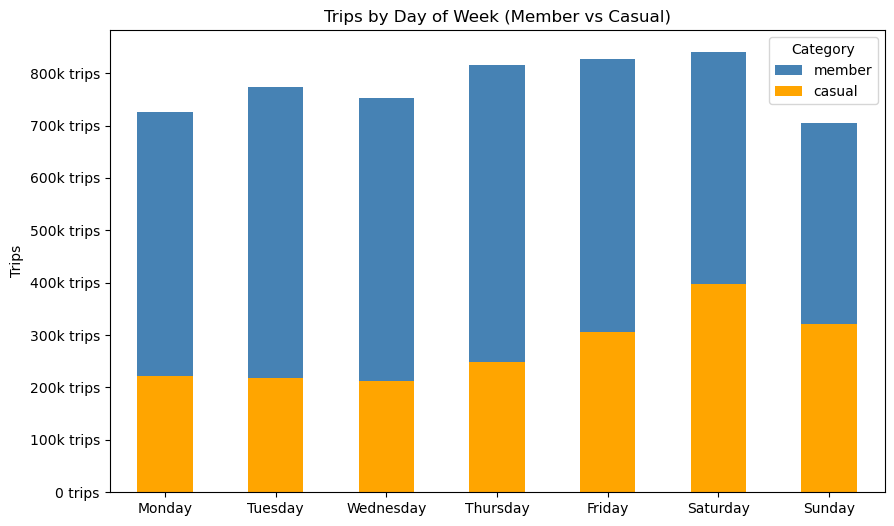

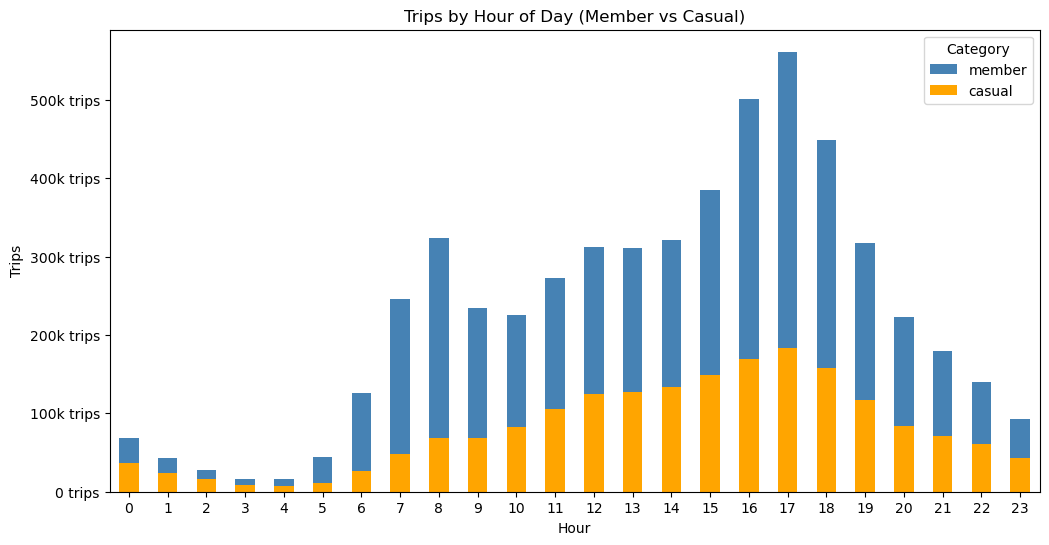

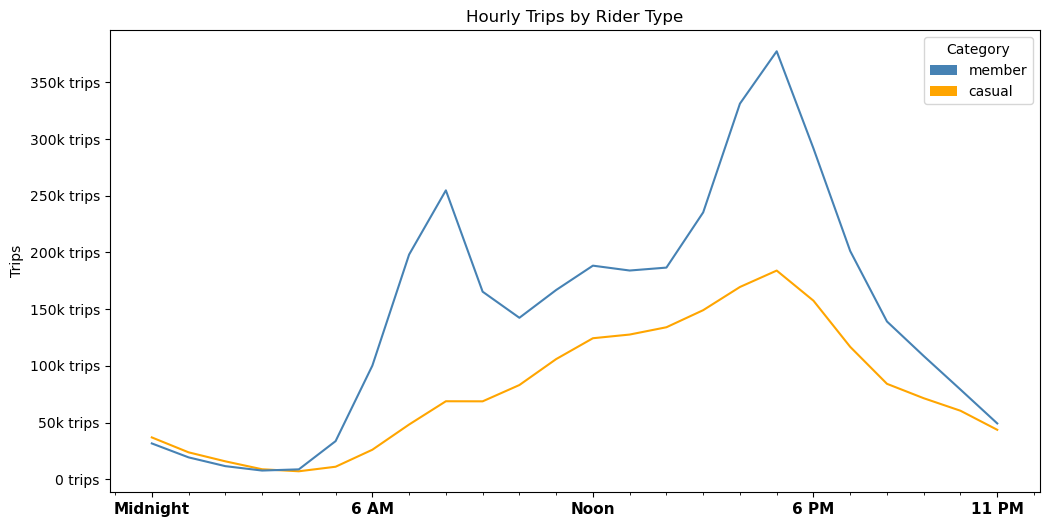

In [95]:
import matplotlib.pyplot as plt
import viz_helpers as vh
import matplotlib.ticker as mticker

# -----------------------------
# 1) Trips by Day of Week (Member vs Casual)
# -----------------------------
weekday_member = (
    df.groupby([df['started_at'].dt.day_name(), 'member_casual'])
      .size()
      .unstack(fill_value=0)
      .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
)

weekday_member.index.name = None   # <-- remove "started_at" index name

ax = vh.plot_with_consistent_colors(
    weekday_member,
    kind='bar',
    stacked=True,
    title="Trips by Day of Week (Member vs Casual)",
    figsize=(10,6),
    category_type="rider",
    format_yaxis="human",
    unit=" trips",
    show_legend=True
)
plt.ylabel("Trips")
plt.xticks(rotation=0)
plt.show()

# -----------------------------
# 2) Trips by Hour of Day (Member vs Casual)
# -----------------------------
hourly_member = (
    df.groupby([df['started_at'].dt.hour, 'member_casual'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

hourly_member.index.name = None   # <-- remove "started_at" index name

ax = vh.plot_with_consistent_colors(
    hourly_member,
    kind='bar',
    stacked=True,
    title="Trips by Hour of Day (Member vs Casual)",
    figsize=(12,6),
    category_type="rider",
    format_yaxis="human",
    unit=" trips",
    show_legend=True
)
plt.xlabel("Hour")
plt.ylabel("Trips")
plt.xticks(rotation=0)
plt.show()

# -----------------------------
# 3) Hourly Trips by Rider Type (Line chart)
# -----------------------------


ax = vh.plot_with_consistent_colors(
    hourly_member,
    kind='line',
    title="Hourly Trips by Rider Type",
    figsize=(12,6),
    category_type="rider",
    format_yaxis="human",
    unit=" trips",
    show_legend=True
)

#plt.xlabel("Hour")
plt.ylabel("Trips")

# Major ticks at key times
major_ticks = [0, 6, 12, 18, 23]
major_labels = ["Midnight", "6 AM", "Noon", "6 PM", "11 PM"]
plt.xticks(major_ticks, major_labels, fontsize=11, fontweight='bold')

# Minor ticks for every hour
ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
ax.tick_params(axis='x', which='minor', labelsize=8)  # smaller font for minor ticks

plt.show()




In [97]:
# Extract day of week
df['day_of_week'] = df['started_at'].dt.day_name()

# Group by day of week and rider type
trips_by_day = df.groupby(['day_of_week','member_casual']).size().reset_index(name='trip_count')

# Order days of week
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
trips_by_day['day_of_week'] = pd.Categorical(trips_by_day['day_of_week'], categories=day_order, ordered=True)


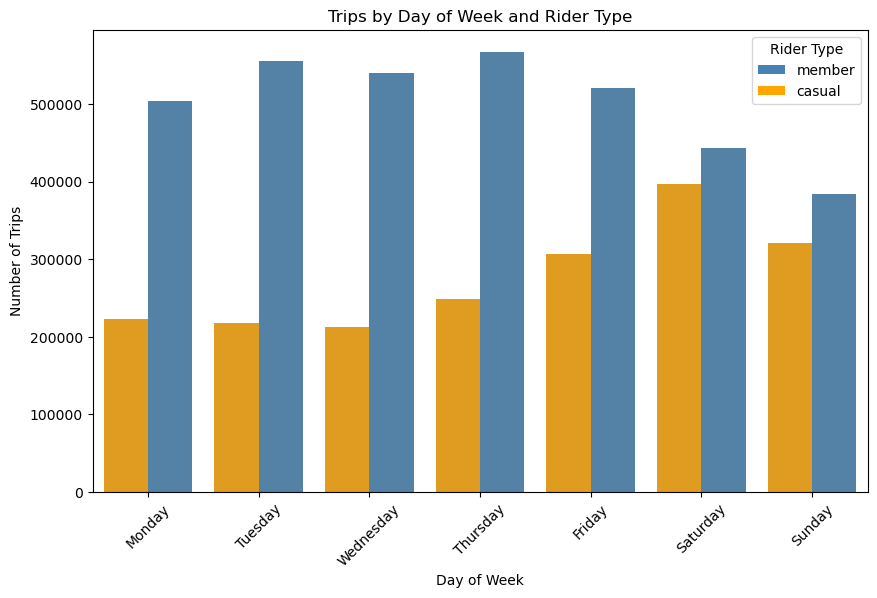

In [99]:
# -----------------------------
# Trips by Day of Week and Rider Type
# -----------------------------
ax = plot_grouped_bar(
    data=trips_by_day,
    x='day_of_week',
    y='trip_count',
    hue='member_casual',
    title="Trips by Day of Week and Rider Type",
    figsize=(10,6),
    category_type="rider"   # enforce Member=steelblue, Casual=orange
)

plt.xlabel("Day of Week")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.show()

